# 集成学习

In [17]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import seaborn as sns
import re, pip
import time
import os

In [18]:
for package in [sklearn,mlp,np,pd,sns,pip]:
    print(re.findall("([^']*)",str(package))[2],package.__version__)

sklearn 1.5.0
matplotlib 3.7.2
numpy 1.26.4
pandas 2.2.2
seaborn 0.12.2
pip 23.0.1


In [19]:
#pip install --upgrade scikit-learn
#conda update scikit-learn

目录

一 梯度提升树的基本思想<br>
&emsp;1 梯度提升树 pk AdaBoost<br>
&emsp;2 GradientBoosting回归与分类的实现<br>
二 梯度提升树的参数<br>
&emsp;1 迭代过程<br>
&emsp;&emsp; 1.1 初始预测结果$H_0$的设置<br>
&emsp;&emsp; 1.2 使用回归器完成分类任务<br>
&emsp;&emsp; 1.3 GBDT的8种损失函数<br>
&emsp;2 弱评估器结构<br>
&emsp;&emsp; 2.1 梯度提升树种的弱评估器复杂度<br>
&emsp;&emsp; 2.2 弗里德曼均方误差<br>
&emsp;3 梯度提升树的提前停止机制<br>
&emsp;4 梯度提升树的袋外数据<br>
&emsp;5 缺失参数class_weight与n_jobs<br>
三 梯度提升树的参数空间与自动优化<br>
&emsp;1 GBDT的参数空间<br>
&emsp;2 基于TPE对GBDT进行优化<br>
四 原理进阶：梯度提升回归树的求解流程<br>
&emsp;1 GBDT的基本数学流程<br>
&emsp;2 初始化H0过程中的常数C是什么？<br>
&emsp;3 伪残差、残差与梯度有什么关系？<br>
&emsp;4 证明：拟合伪残差的合理性<br>

# 一 梯度提升树的基本思想

## 1 梯度提升树 pk AdaBoost

梯度提升树（Gradient Boosting Decision Tree，GBDT）是提升法中的代表性算法，它即是当代强力的XGBoost、LGBM等算法的基石，也是工业界应用最多、在实际场景中表现最稳定的机器学习算法之一。在最初被提出来时，GBDT被写作梯度提升机器（Gradient Boosting Machine，GBM），它融合了Bagging与Boosting的思想、扬长避短，可以接受各类弱评估器作为输入，在后来弱评估器基本被定义为决策树后，才慢慢改名叫做梯度提升树。受Boosting算法首个发扬光大之作AdaBoost的启发，GBDT中自然也包含Boosting三要素：

- 损失函数$L(x,y)$ ：用以衡量模型预测结果与真实结果的差异
- 弱评估器$f(x)$ ：（一般为）决策树，不同的boosting算法使用不同的建树过程
- 综合集成结果$H(x)$：即集成算法具体如何输出集成结果

同时，GBDT也遵循boosting算法的基本流程进行建模：

---
**<font color="green"><center>依据上一个弱评估器$f(x)_{t-1}$的结果，计算损失函数$L(x,y)$，
    <br>并使用$L(x,y)$自适应地影响下一个弱评估器$f(x)_t$的构建。<br>集成模型输出的结果，受到整体所有弱评估器$f(x)_0$ ~ $f(x)_T$的影响。</center></font>**
---

但与AdaBoost不同的是，GBDT在整体建树过程中做出了以下几个关键的改变：

- **弱评估器**

> GBDT的弱评估器输出类型不再与整体集成算法输出类型一致。对于AdaBoost或随机森林算法来说，当集成算法执行的是回归任务时，弱评估器也是回归器，当集成算法执行分类任务时，弱评估器也是分类器。但对于GBDT而言，**无论GBDT整体在执行回归/分类/排序任务，弱评估器一定是回归器**。GBDT通过sigmoid或softmax函数输出具体的分类结果，但实际弱评估器一定是回归器。

<br>

- **损失函数$L(x,y)$**

> 在GBDT当中，损失函数范围不再局限于固定或单一的某个损失函数，而从数学原理上推广到了任意可微的函数。因此GBDT算法中可选的损失函数非常多，GBDT实际计算的数学过程也与损失函数的表达式无关。<br>

<br>

- **拟合残差**

> GBDT依然自适应调整弱评估器的构建，但却不像AdaBoost一样通过调整数据分布来**间接**影响后续弱评估器。相对的，GBDT通过修改后续弱评估器的拟合目标来直接影响后续弱评估器的结构。<br><br>
> 具体地来说，在AdaBoost当中，每次建立弱评估器之前需要修改样本权重，且用于建立弱评估器的是样本$X$以及对应的$y$，在GBDT当中，我们不修改样本权重，但每次用于建立弱评估器的是样本$X$以及当下集成输出$H(x_i)$与真实标签$y$的差异（$y - H(x_i)$）。这个差异在数学上被称之为残差（Residual），因此**GBDT不修改样本权重，而是通过拟合残差来影响后续弱评估器结构**。<br>

<br>

- **抽样思想**

> GBDT加入了随机森林中随机抽样的思想，在每次建树之前，允许对样本和特征进行抽样来增大弱评估器之间的独立性（也因此可以有袋外数据集）。虽然Boosting算法不会大规模地依赖于类似于Bagging的方式来降低方差，但由于Boosting算法的输出结果是弱评估器结果的加权求和，因此Boosting原则上也可以获得由“平均”带来的小方差红利。当弱评估器表现不太稳定时，采用与随机森林相似的方式可以进一步增加Boosting算法的稳定性。

<br>

除了以上四个改变之外，GBDT的求解流程与AdaBoost大致相同。因此，如果你对AdaBoost的流程相当熟悉，GBDT的建模过程并不难懂。sklearn当中集成了GBDT分类与GBDT回归，我们使用如下两个类来调用它们：

*class* `sklearn.ensemble.GradientBoostingClassifier`(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

*class* `sklearn.ensemble.GradientBoostingRegressor`(*, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

比起AdaBoost，GBDT的超参数数量增加了不少，但与其他集成算法一样，GBDT回归器与GBDT分类器的超参数高度一致（实际上，对GBDT来说，是完全一致）。在课程当中，我们将重点介绍GBDT独有的参数，以及GBDT分类器与GBDT回归器中表现不一致的参数。

## 2 GradientBoosting的实现

In [20]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import cross_validate, KFold

In [21]:
data = pd.read_csv(r"..\datasets\House Price\train_encode.csv",index_col=0)

In [22]:
data.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态,SalePrice
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0,208500
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0,181500
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0,223500
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,140000
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0,250000


In [23]:
#回归数据
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [24]:
X.shape

(1460, 80)

In [25]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [26]:
#定义所需的交叉验证方式
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

def RMSE(result,name):
    return abs(result[name].mean())

- 梯度提升回归树

In [27]:
gbr = GBR(random_state=1412) #实例化
result_gbdt = cross_validate(gbr,X,y,cv=cv
                             ,scoring="neg_root_mean_squared_error" #负根均方误差
                             ,return_train_score=True
                             ,verbose=True
                             ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


In [28]:
result_gbdt

{'fit_time': array([1.0338974 , 1.06256342, 1.04455757, 1.0415566 , 1.03955603]),
 'score_time': array([0.        , 0.        , 0.        , 0.01501107, 0.        ]),
 'test_score': array([-25841.43338683, -44920.79906295, -24242.00022617, -20817.99371904,
        -28097.54532128]),
 'train_score': array([-13716.93826094, -13750.03069928, -14480.27626562, -14515.79537532,
        -13490.91346828])}

In [29]:
RMSE(result_gbdt,"train_score")

13990.790813889864

In [30]:
RMSE(result_gbdt,"test_score")

28783.954343252786

- 梯度提升回归与其他算法的对比

In [31]:
modelname = ["GBDT","RF","AdaBoost","RF-TPE","Ada-TPE"]

models = [GBR(random_state=1412)
         ,RFR(random_state=1412,n_jobs=-1)
         ,ABR(random_state=1412)
         ,RFR(n_estimators=89, max_depth=22, max_features=14, min_impurity_decrease=0
              ,random_state=1412, verbose=False, n_jobs=-1)
         ,ABR(n_estimators=39, learning_rate=0.94,loss="exponential"
              ,random_state=1412)]

colors = ["green","gray","orange","red","blue"]

In [32]:
for name,model in zip(modelname,models):
    start = time.time()
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    end = time.time()-start
    print(name)
    print("\t train_score:{:.3f}".format(RMSE(result,"train_score")))
    print("\t test_score:{:.3f}".format(RMSE(result,"test_score")))
    print("\t time:{:.2f}s".format(end))
    print("\n")

GBDT
	 train_score:13990.791
	 test_score:28783.954
	 time:1.00s


RF
	 train_score:11177.272
	 test_score:30571.267
	 time:2.49s


AdaBoost
	 train_score:27062.107
	 test_score:35345.931
	 time:0.61s


RF-TPE
	 train_score:11208.818
	 test_score:28346.673
	 time:0.69s


Ada-TPE
	 train_score:27401.542
	 test_score:35169.730
	 time:0.49s




|算法|RF|AdaBoost|GBDT|RF<br>(TPE)|AdaBoost<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|0.7s|0.25s|0.49s|0.22s|0.23s|
|最优分数<br>(RMSE)|30571.267|35345.931|28783.954|28346.673|35169.730|

先来看默认参数下所有算法的表现。当不进行调参时，随机森林的运行时间最长、AdaBoost最快，GBDT居中，但考虑到AdaBoost的`n_estimators`参数的默认值为50，而GBDT和随机森林的`n_estimators`默认值都为100，可以认为AdaBoost的运行速度与GBDT相差不多。从结果来看，未调参状态下GBDT的结果是最好的，其结果甚至与经过TPE精密调参后的随机森林结果相差不多，而AdaBoost经过调参后没有太多改变，可以说AdaBoost极其缺乏调参空间、并且学习能力严重不足。

基于以上信息，我们可以观察三个算法的过拟合情况：

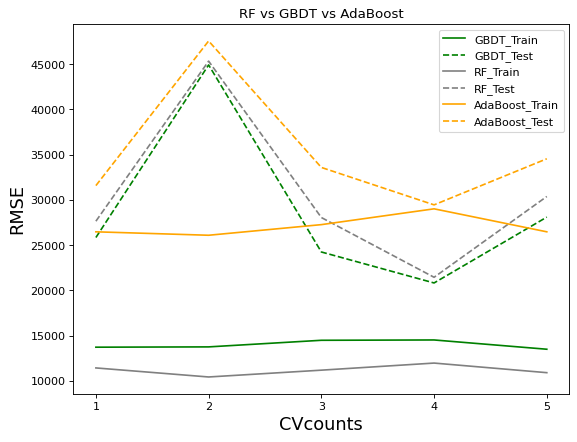

In [33]:
xaxis = range(1,6)
plt.figure(figsize=(8,6),dpi=80)

for name,model,color in zip(modelname[:3],models[:3],colors[:3]):
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    plt.plot(xaxis,abs(result["train_score"]), color=color, label = name+"_Train")
    plt.plot(xaxis,abs(result["test_score"]), color=color, linestyle="--",label = name+"_Test")

plt.xticks([1,2,3,4,5])
plt.xlabel("CVcounts",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.title("RF vs GBDT vs AdaBoost")
plt.legend()
plt.show()

不难发现，AdaBoost是过拟合程度最轻的，这也反映出它没有调参空间的事实，而GBDT与随机森林过拟合程度差不多，不过GBDT的过拟合程度相对较轻一些，这是因为**Boosting算法的原理决定了Boosting算法更加不容易过拟合**，这一点在后续讲解GBDT的参数时我们会详细说明。

我们可以绘制随机森林调参前后、以及AdaBoost调参前后的结果对比：

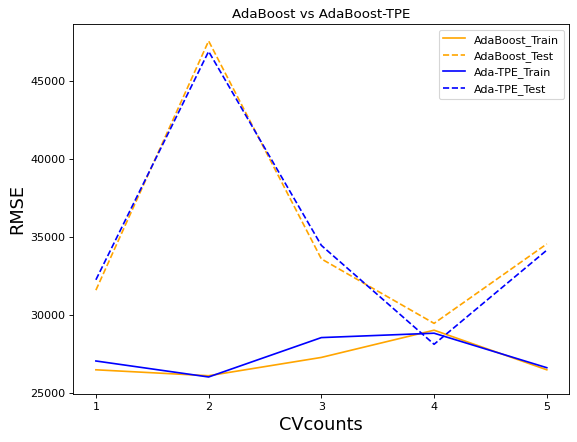

In [34]:
xaxis = range(1,6)
plt.figure(figsize=(8,6),dpi=80)

for name,model,color in zip(modelname[2:5:2],models[2:5:2],colors[2:5:2]):
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    plt.plot(xaxis,abs(result["train_score"]), color=color, label = name+"_Train")
    plt.plot(xaxis,abs(result["test_score"]), color=color, linestyle="--",label = name+"_Test")

plt.xticks([1,2,3,4,5])
plt.xlabel("CVcounts",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.title("AdaBoost vs AdaBoost-TPE")
plt.legend()
plt.show()

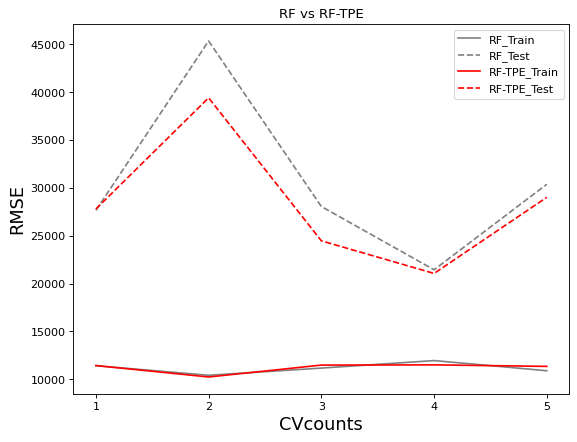

In [35]:
xaxis = range(1,6)
plt.figure(figsize=(8,6),dpi=80)

for name,model,color in zip(modelname[1:4:2],models[1:4:2],colors[1:4:2]):
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    plt.plot(xaxis,abs(result["train_score"]), color=color, label = name+"_Train")
    plt.plot(xaxis,abs(result["test_score"]), color=color, linestyle="--",label = name+"_Test")

plt.xticks([1,2,3,4,5])
plt.xlabel("CVcounts",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.title("RF vs RF-TPE")
plt.legend()
plt.show()

不难发现，AdaBoost在经过精密调参后，并没有太多改变，而随机森林调参后过拟合程度明显降低，测试集上的结果明显提升，这是随机森林在潜力和根本原则上都比AdaBoost要强大的表现。那GBDT的表现如何呢？GBDT在默认参数上的结果接近经过TPE调参后的随机森林，我们来看看这两个算法的对比：

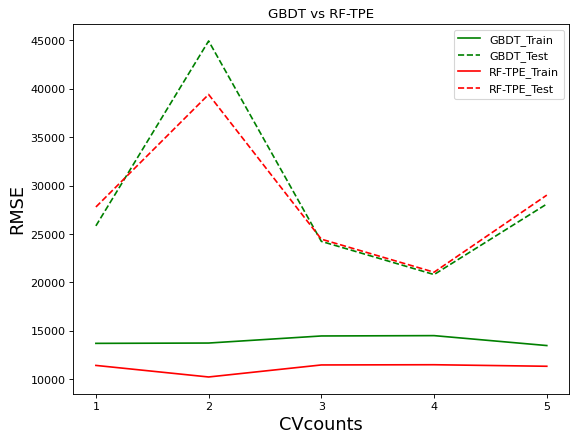

In [36]:
xaxis = range(1,6)
plt.figure(figsize=(8,6),dpi=80)

for name,model,color in zip(modelname[:5:3],models[:5:3],colors[:5:3]):
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    plt.plot(xaxis,abs(result["train_score"]), color=color, label = name+"_Train")
    plt.plot(xaxis,abs(result["test_score"]), color=color, linestyle="--",label = name+"_Test")

plt.xticks([1,2,3,4,5])
plt.xlabel("CVcounts",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.title("GBDT vs RF-TPE")
plt.legend()
plt.show()

不难发现，GBDT的过拟合程度是轻于优化后的随机森林的。并且，在大部分交叉验证的结果下，GBDT的效果都接近或好于优化后的随机森林。在cv=2时GBDT的表现远不如森林，一次糟糕的表现拉低了GBDT的整体表现，否则GBDT可能在默认参数上表现出比优化后的随机森林更好的结果。如果我们可以通过调参优化让GBDT的表现更加稳定，GBDT可能会出现惊人的表现。

- 梯度提升树分类

In [37]:
#分类数据
X_clf = data.iloc[:,:-2]
y_clf = data.iloc[:,-2]

In [38]:
np.unique(y_clf) #6分类

array([0., 1., 2., 3., 4., 5.])

In [39]:
#GBDT分类的实现
clf = GBC(random_state=1412) #实例化
cv = KFold(n_splits=5,shuffle=True,random_state=1412)
result_clf = cross_validate(clf,X_clf,y_clf,cv=cv
                            ,return_train_score=True
                            ,verbose=True
                            ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


In [40]:
result_clf

{'fit_time': array([5.61809015, 5.61512351, 5.5331068 , 5.59266448, 5.52626681]),
 'score_time': array([0.01501036, 0.01501036, 0.        , 0.01643157, 0.        ]),
 'test_score': array([0.89726027, 0.89041096, 0.90068493, 0.89041096, 0.90753425]),
 'train_score': array([0.99058219, 0.99315068, 0.99229452, 0.99143836, 0.99143836])}

In [41]:
result_clf["train_score"].mean()

0.9917808219178083

In [42]:
result_clf["test_score"].mean()

0.8972602739726028

# 二 梯度提升树的参数

*class* `sklearn.ensemble.GradientBoostingClassifier`(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

*class* `sklearn.ensemble.GradientBoostingRegressor`(*, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

与随机森林一样，由于GBDT超参数数量较多，因此我们可以将GBDT的参数分为以下5大类别，其中标注为绿色的参数包括了我们未曾学过的知识、需要重点讲解：

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：n_estimators, learning_rate, **<font color="green">loss, alpha, init</font>**<br>属性：<font color="green">**loss_, init_, estimators_**</font>|
|**弱评估器结构**|<font color="green">**criterion**</font>, max_depth, min_samples_split, min_samples_leaf, <br>min_weight_fraction_leaf, max_leaf_nodes,<br>min_impurity_decrease|
|**提前停止**|参数：<font color="green">**validation_fraction, n_iter_no_change, tol**</font><br>属性：<font color="green">**n_estimators_**</font>|
|**弱评估器的训练数据**|参数：subsample, max_features, random_state<br>属性：<font color="green">**oob_improvement, train_score_**</font>|
|**其他**|ccp_alpha, warm_start|

## 1 迭代过程

之前我们提到过，GBDT的整体建模流程与AdaBoost高度相似，因此GBDT当中也有设置具体迭代次数（弱评估器次数）的参数`n_estimators`与学习率参数`learning_rate`，这两个参数的含义、以及对集成算法的影响与AdaBoost当中完全一致。

具体地来说，对于样本$x_i$，集成算法当中一共有$T$棵树，则参数`n_estimators`的取值为T。假设现在正在建立第$t$个弱评估器，则则第$t$个弱评估器上$x_i$的结果可以表示为$f_t(x_i)$。假设整个Boosting算法对样本$x_i$输出的结果为$H(x_i)$，则该结果一般可以被表示为t=1~t=T过程当中，所有弱评估器结果的加权求和：

$$H(x_i) =  \sum_{t=1}^\boldsymbol{\color{red}T}\phi_tf_t(x_i)$$

其中，$\phi_t$为第t棵树的权重。对于第$t$次迭代来说，则有：

$$H_t(x_i) = H_{t-1}(x_i) + \phi_tf_t(x_i)$$

在这个一般过程中，每次将本轮建好的决策树加入之前的建树结果时，可以在权重$\phi$前面增加参数$\color{red}\eta$，表示为第t棵树加入整体集成算法时的学习率，对标参数`learning_rate`。

$$H_t(x_i) = H_{t-1}(x_i) + \boldsymbol{\color{red}\eta} \phi_tf_t(x_i)$$

该学习率参数控制Boosting集成过程中$H(x_i)$的增长速度，是相当关键的参数。当学习率很大时，$H(x_i)$增长得更快，我们所需的`n_estimators`更少，当学习率较小时，$H(x_i)$增长较慢，我们所需的`n_estimators`就更多，因此boosting算法往往会需要在`n_estimators`与`learning_rate`中做出权衡。

这两个参数的使用方法与AdaBoost中也完全一致，故此处不再赘述，后续我们会直接使用这两个参数进行调参。

### 1.1 初始预测结果$H_0$的设置

在上述过程中，我们建立第一个弱评估器时有：

$$H_1(x_i) = H_{0}(x_i) + \phi_1f_1(x_i)$$

由于没有第0棵树的存在，因此$H_0(x_i)$的值在数学过程及算法具体实现过程中都需要进行单独的确定，这一确定过程由参数`init`确定。

- 参数`init`：输入计算初始预测结果$H_0$的估计器对象。

在该参数中，可以输入任意评估器、字符串"zero"、或者None对象，默认为None对象。
> 当输入任意评估器时，评估器必须要具备fit以及predict_proba功能，即我们可以使用决策树、逻辑回归等可以输出概率的模型。如果输出一个已经训练过、且精细化调参后的模型，将会给GBDT树打下坚实的基础。<br><br>
> 填写为字符串"zero"，则代表令$H_0 = 0$来开始迭代。<br><br>
> 不填写，或填写为None对象，sklearn则会自动选择类`DummyEstimator`中的某种默认方式进行预测作为$H_0$的结果。`DummyEstimator`类是sklearn中设置的使用超简单规则进行预测的类，其中最常见的规则是直接从训练集标签中随机抽样出结果作为预测标签，也有选择众数作为预测标签等选项。

一般在GBDT类的使用过程中，我们不会主动调节参数`init`，但是当我们有足够的算力支持超参数搜索时，我们可以在`init`上进行选择。

In [43]:
from sklearn.tree import DecisionTreeRegressor as DTR

In [44]:
tree_reg = DTR(random_state=1412)
rf = RFR(n_estimators=89, max_depth=22, max_features=14, min_impurity_decrease=0
              ,random_state=1412, verbose=False, n_jobs=-1)

In [45]:
for init in [tree_reg,rf,"zero",None]:
    reg = GBR(init = init,random_state=1412)
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    result_reg = cross_validate(reg,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                                ,return_train_score=True
                                ,verbose=False
                                ,n_jobs=-1)
    print("\n")
    print(RMSE(result_reg,"train_score"))
    print(RMSE(result_reg,"test_score"))



0.0
42065.93924112058


5669.291478825804
27215.347804271132


13990.791639702458
28739.882050269225


13990.790813889864
28783.954343252786


不难发现，初始参数的具体输入会对模型的最终结果造成巨大影响，在init中输入训练好的模型会加重GBDT的过拟合，但同时也可能得到更好的测试集结果。我们甚至可以无限套娃，让init参数中输入被训练好的GBDT模型，当然，这样做的结果往往是过拟合被放大到无法挽回了。通常来说，我们还是会选择"zero"作为init的输入。

与参数`init`相对的属性就是`init_`，当模型被拟合完毕之后，我们可以使用该属性来返回输出$H_0$的评估器对象。

In [46]:
reg = GBR(init = None,random_state=1412)
reg.fit(X,y).init_ #返回sklearn中的玩具评估器DummyRegressor

DummyRegressor()

In [47]:
reg = GBR(init = rf,random_state=1412)
reg.fit(X,y).init_

RandomForestRegressor(max_depth=22, max_features=14, min_impurity_decrease=0,
                      n_estimators=89, n_jobs=-1, random_state=1412,
                      verbose=False)

当然，在init中的值是我们自己输入的值的情况下，属性`init_`略显鸡肋，但我们或许会预见需要该属性的具体场景，例如在建模过程中进行监控打印时、或在大量初始化模型中选择最佳初始化模型时。

### 1.2 使用回归器完成分类任务

GBDT与AdaBoost及随机森林的关键区别之一，是GBDT中所有的弱评估器都是回归树，因此在实际调用梯度提升树完成分类任务时，需要softmax函数或sigmoid函数对回归树输出的结果进行处理。因此，对于二分类情况来说，集成算法对样本$x_i$输出的结果为：

$$H(x_i) =  \sum_{t=1}^\boldsymbol{\color{red}T}\phi_tf_t(x_i)$$

$$ p(\hat{y}_i = 1 |x_i) = \sigma(H(x_i))$$

其中$\sigma$是sigmoid函数，当$p(\hat{y}_i = 1 |x_i)$大于0.5时，样本$x_i$的预测类别为1，反之则为0。

而对多分类来说，情况就比较复杂了。在讲解AdaBoost时我们说明过，二分类当中我们只需求解一个概率$P(Y=1)$，因为$P(Y=0) = 1 - P(Y=1)$，因此$P(Y=1)$大于0.5时预测标签为1，否则预测标签为0。但在多分类当中，我们必须求解出所有标签类别所对应的概率，在所有这些概率当中，最大概率所对应的标签才是多分类的预测标签。GBDT对于多分类也只能输出集成算法回归结果$H(x_i)$，因此我们需要使用**softmax函数**帮助我们将回归值转化为概率，而**Softmax函数是接受K个连续型结果，并输出K个相对概率的函数**。

一般我们在使用softmax函数时，3分类问题则需要向softmax函数输入3个值，4分类问题则需要向softmax函数输入4个值，以此类推，最终softmax函数输出的是与输入值同等数量的相对概率，而多分类算法的预测标签是相对概率最高的类别。因此，在使用softmax函数前，我们需要准备好与类别数量相当的$H(x_i)$。

具体来说，当现在的问题是$K$分类、且每个类别为$[1,2,3...k]$时，我们则分别按照$y = 1, y = 2,...,y = k$进行建模，总共建立$K$棵树，每棵树输出的结果为：

$$H^1(x_i), H^2(x_i),...,H^k(x_i)$$

总共$K$个输出结果。然后，我们分别将$H^1(x_i)$到$H^k(x_i)$的结果输入softmax，来计算出每个标签类别所对应的概率。具体地来说，softmax函数的表达式为：

$$Softmax(H^k(x)) = \frac{e^{H^k(x)}}{\sum_{k=1}^Ke^{H_k(x)}}$$

其中$e$为自然常数，$H$是集成算法的输出结果，$K$表示标签中的类别总数为$K$，如三分类时$K=3$，四分类时$K=4$，$k$表示任意标签类别，$H_k$则表示以类别$k$为真实标签进行训练而得出的$H$。不难发现，Softmax函数的分子时多分类状况下**某一个标签类别的H(x)的指数函数**，而分母时多分类状况下**所有标签类别的H(x)的指数函数之和**，因此Softmax函数的结果代表了样本的预测标签为类别$k$的概率。假设现在是三分类[1,2,3]，则样本$i$被分类为1类的概率为：

$$
\begin{aligned}
p^1(x_i) &= \frac{e^{H^1(x)}}{\sum_{k=1}^Ke^{H_k(x)}} \\
&= \frac{e^{H^1(x)}}{e^{H^1(x)}+e^{H^2(x)}+e^{H^3(x)}}\\
\end{aligned}$$

最终得到$K$个相对概率$p^k(x_i)$，并求解出相对概率最高的类别。不难发现，当执行多分类时，这一计算流程中涉及到的计算量以及弱评估器数量都会远远超出二分类以及回归类问题。实际上，在执行多分类任务时，如果我们要求模型迭代10次，模型则会按照实际的多分类标签数n_classes建立10 * n_classes个弱评估器。对于这一现象，我们可以通过属性`n_estimators_`以及属性`estimators_`查看到。

- `n_estimators_`：实际迭代次数，`estimators_`：实际建立的弱评估器数量

In [91]:
clf = GBC(n_estimators=10 #迭代次数为10次
          ,random_state=1412)

In [92]:
X_clf.shape #查看X与y的结果

(1460, 79)

In [93]:
np.unique(y_clf) #多分类，现在为6分类

array([0., 1., 2., 3., 4., 5.])

In [94]:
clf = clf.fit(X_clf,y_clf)

In [95]:
clf.n_estimators_ #实际迭代数量为10

10

In [96]:
clf.estimators_.shape #但每次迭代时其实建立了6个评估器

(10, 6)

In [102]:
clf.estimators_[0] #其中一次迭代中建立的全部评估器

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x19DCD46B140)],
      dtype=object)

- 如果是二分类则不会出现这种现象

In [97]:
from sklearn.datasets import load_breast_cancer

In [98]:
X_clf2 = load_breast_cancer().data
y_clf2 = load_breast_cancer().target

In [ ]:
np.unique(y_clf2)

In [99]:
clf = GBC(n_estimators=10,random_state=1412)
clf = clf.fit(X_clf2,y_clf2)

In [100]:
clf.n_estimators_

10

In [63]:
clf.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x19DCD468E40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x19DCD468E40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x19DCD468E40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x19DCD468E40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x19DCD468E40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x19DCD468E40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
             

这一现象只在弱评估器为回归器的各类boosting算法中出现，对于弱评估器可以是回归树也可以是分类树的随机森林、Adaboost来说，多分类时每个类别对应的概率是在叶子节点上自然生成的。因为有此区别，因此多分类问题在随机森林上的计算可能会表现得更快。

### 1.3 GBDT的8种损失函数

作为基于AdaBoost改进的Boosting算法，GBDT的功绩之一是将损失函数从有限的指数损失、MSE等推广到了任意可微函数，因此GBDT的损失函数选择异常丰富，因此我们可以在调参时加入损失函数作为需要调整的参数进行考量。在sklearn中，控制具体损失函数的参数为`loss`。

GBDT中的损失函数因GBDT具体执行的预测任务而存在区别，同时也因标签的分布而存在区别。对于梯度提升分类树来说，loss的备选项有如下几种：

- 分类器中的`loss`：字符串型，可输入"deviance", "exponential"，默认值="deviance"

其中"deviance"直译为偏差，特指逻辑回归的损失函数——交叉熵损失，而"exponential"则特指AdaBoost中使用的指数损失函数。对任意样本$i$而言，$y_i$为真实标签，$\hat{y_i}$为预测标签，$H(x_i)$为集成算法输出结果，$p(x_i)$为基于$H(x_i)$和sigmoid/softmax函数计算的概率值。则各个损失的表达式为：

**二分类交叉熵损失**——<br><br>
$$L = -\left( y\log p(x) + (1 - y)\log(1 - p(x)) \right)$$

<br>注意，log当中输入的一定是概率值。对于逻辑回归来说，概率就是算法的输出，因此我们可以认为逻辑回归中$p = H(x)$，但对于GBDT来说，$p(x_i) = Sigmoid(H(x_i))$，这一点一定要注意。

<br>

**多分类交叉熵损失**，总共有K个类别——<br><br>

$$L = -\sum_{k=1}^Ky^*_k\log(P^k(x))$$

其中，$P^k(x)$是概率值，对于多分类GBDT来说，$p^k(x) = Softmax(H^k(x))$。$y^*$是由真实标签转化后的向量。例如，在3分类情况下，真实标签$y_i$为2时，$y^*$为[$y^*_{1}$,$y^*_{2}$,$y^*_{3}$]，取值分别为：

|$y^*_{1}$|$y^*_{2}$|$y^*_{3}$|
|:-:|:-:|:-:|
|$0$|$1$|$0$|

这一转化过程与AdaBoost中多分类指数损失中的转化高度相似。

**二分类指数损失**——<br><br>
$$L = e^{-yH(x)}$$<br>

**多分类指数损失**，总共有K个类别——<br><br>

$$
\begin{aligned}
L &=exp \left( -\frac{1}{K}\boldsymbol{y^* · H^*(x)} \right) \\ 
& = exp \left( -\frac{1}{K}(y^1H^1(x)+y^2H^2(x) \ + \  ... + y^kH^k(x)) \right)
\end{aligned}
$$<br>

需要注意，指数损失中的$y^*$与交叉熵损失中的$y^*$不是同样的向量。我们已经在逻辑回归的章节中详解过交叉熵损失，在AdaBoost的章节当中详解过指数损失，因此这里便不再展开赘述了。需要注意的是，一般梯度提升分类器默认使用交叉熵损失，如果使用指数损失，则相当于执行没有权重调整的AdaBoost算法。

对于梯度提升回归树来说，loss的备选项有如下几种：

- 回归器中的`loss`：字符串型，可输入{"squared_error", "absolute_error", "huber", "quantile"}，默认值="squared_error"

其中'squared_error'是指回归的平方误差，'absolute_error'指的是回归的绝对误差，这是一个鲁棒的损失函数。'huber'是以上两者的结合。'quantile'则表示使用分位数回归中的弹球损失pinball_loss。对任意样本$i$而言，$y_i$为真实标签，$H(x_i)$为预测标签，则各个损失的表达式为：

**平方误差**——<br><br>

$$L = \sum{(y_i - H(x_i))^2}$$

<br>

**绝对误差**——<br><br>

$$L = \sum{|y_i - H(x_i)|}$$

<br>

**Huber损失**——

$$L = \sum{l(y_i,H(x_i))}$$

其中$$l = \begin{split} 
\begin{cases}\frac{1}{2}(y_i - H(x_i))^2, & |y_i - H(x_i)|\leq\alpha \\
\alpha(|y_i - H(x_i)|-\frac{\alpha}{2}),& |y_i - H(x_i)|>\alpha \end{cases}\end{split}, \space \space \alpha \in (0, 1)$$

<br>

**quantile损失**——

$$L = \sum{l(y_i,H(x_i))}$$

其中$$l = \begin{split} 
\begin{cases}
    \alpha (y_i - H(x_i)), & y_i - H(x_i) > 0 \\
    0,    & y_i - H(x_i) = 0 \\
    (1-\alpha) (y_i - H(x_i)), & y_i - H(x_i) < 0
\end{cases}\end{split}, \space \space \alpha \in (0, 1)$$

其中$\alpha$是需要我们自己设置的超参数，由参数`alpha`控制。在huber损失中，alpha是阈值，在quantile损失中，alpha用于辅助计算损失函数的输出结果，默认为0.9。

**<font color=red>===更新警告===</font>**<br>
在sklearn1.0版本及后续版本当中，损失函数"ls"与"lad"被删除了，其中"ls"的功能被"squared_error"取代，而"lad"被"absolute_error"取代。如果你在运行代码时，发现你的参数默认值、参数名称与课件中不相同，或者在运行过程中出现报错、警告等现象，你可能需要更新你的sklearn。

对于相同的样本、相同的差异，不同损失函数给出的损失值不同

In [ ]:
yi = 10
Hx = 8

In [ ]:
绝对 - 2
平方 - 4 - 差异>1，误差被放大，差异<1，误差是会被缩小

- 如何选择不同的损失函数？

GBDT是工业应用最广泛的模型，工业数据大部分都极度偏态、具有长尾，因此GBDT必须考虑**离群值**带来的影响。数据中的离群值会极大程度地影响模型地构建，当离群值在标签当中、而我们是依赖于减小损失函数来逐渐构建算法时，这种影响会前所未有地大。**因此Boosting是天生更容易被离群值影响的模型、也更擅长学习离群值的模型。**<br><br>

![](https://discourse-cloud-file-uploads.s3.dualstack.us-west-2.amazonaws.com/business6/uploads/analyticsvidhya/original/1X/c3af040fef3ddc8f2bb1b393d71700e9a638426e.PNG)
![](https://discourse-cloud-file-uploads.s3.dualstack.us-west-2.amazonaws.com/business6/uploads/analyticsvidhya/original/1X/f3c5885defae011dd385462f1f3812ff24393105.PNG)

举例来说，若离群值的标签为1000，大部分正常样本的标签在0.1~0.2之间，算法一定会异常努力地学习离群值的规律，因为将离群值预测错误会带来巨大的损失。在这种状况下，最终迭代出的算法可能是严重偏离大部分数据的规律的。同样，我们也会遇见很多离群值对我们很关键的业务场景：例如，电商中的金额离群用户可能是VIP用户，风控中信用分离群的用户可能是高风险用户，这种状况下我们反而更关注将离群值预测正确。不同的损失函数可以帮助我们解决不同的问题——

- **当高度关注离群值、并且希望努力将离群值预测正确时，选择平方误差**<br><br>
这在工业中是大部分的情况。在实际进行预测时，离群值往往比较难以预测，因此离群样本的预测值和真实值之间的差异一般会较大。MSE作为预测值和真实值差值的平方，会放大离群值的影响，会让算法更加向学习离群值的方向进化，这可以帮助算法更好地预测离群值。

- **努力排除离群值的影响、更关注非离群值的时候，选择绝对误差**<br><br>
MAE对一切样本都一视同仁，对所有的差异都只求绝对值，因此会保留样本差异最原始的状态。相比其MSE，MAE对离群值完全不敏感，这可以有效地降低GBDT在离群值上的注意力。

- **试图平衡离群值与非离群值、没有偏好时，选择Huber或者Quantileloss**<br><br>
Huberloss损失结合了MSE与MAE，在Huber的公式中，当预测值与真实值的差异大于阈值时，则取绝对值，小于阈值时，则取平方。在真实数据中，部分离群值的差异会大于阈值，部分离群值的差异会小于阈值，因此比起全部取绝对值的MAE，Huberloss会将部分离群值的真实预测差异求平方，相当于放大了离群值的影响（但这种影响又不像在MSE那样大）。因此HuberLoss是位于MSE和MAE之间的、对离群值相对不敏感的损失。

- 属性`loss_`

In [35]:
reg = GBR(n_estimators=10,random_state=1412).fit(X,y)

In [37]:
reg.loss #返回具体的损失函数对象，而不会返回公式

'squared_error'

In [40]:
reg.n_estimators

10

总结一下，在整个迭代过程中，我们涉及到了如下参数及属性：

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：<br><br>&emsp;n_estimators：集成算法中弱评估器数量，对Boosting算法而言为实际迭代次数<br><br>&emsp;learning_rate：Boosting算法中的学习率，影响弱评估器结果的加权求和过程<br><br>&emsp;<font color="green">**loss, alpha**</font>：需要优化的损失函数，以及特定损失函数需要调节的阈值<br><br>&emsp;<font color="green">**init**</font>：初始化预测结果$H_0$的设置<br><br>属性：<br><br>&emsp;<font color="green">**loss_**</font>：返回具体的损失函数对象<br><br>&emsp;<font color="green">**init_**</font>：返回具体的初始化设置<br><br>&emsp;<font color="green">**estimators_**</font>：返回实际建立的评估器列表<br><br>&emsp;n_estimators_：返回实际迭代次数|

## 2 弱评估器结构

在讲解决策树时，我们已经系统地讲解过弱评估器相关的一系列减枝参数，而在讲解随机森林时，我们又明确了这些减枝参数如何影响集成算法。因此我们对于Boosting算法中控制弱评估器的参数可谓非常熟悉：

|类型|参数|
|----|----|
|**弱评估器结构**|<font color="green">**criterion**</font>：弱评估器分枝时的不纯度衡量指标<br><br>max_depth：弱评估器被允许的最大深度，默认3<br><br>min_samples_split：弱评估器分枝时，父节点上最少要拥有的样本个数<br><br>min_samples_leaf：弱评估器的叶子节点上最少要拥有的样本个数<br><br>min_weight_fraction_leaf：当样本权重被调整时，叶子节点上最少要拥有的样本权重<br><br>max_leaf_nodes：弱评估器上最多可以有的叶子节点数量<br><br>min_impurity_decrease：弱评估器分枝时允许的最小不纯度下降量|

这些参数在随机森林中的**用法与默认值**与决策树类`DecisionTreeRegressor`中完全一致，专门用于对决策树进行剪枝、控制单个弱评估器的结构，考虑到大家在决策树中已经充分掌握这些参数，我们不再对这些参数一一进行详细说明了。在这里，需要重点说明的有两部分内容，一部分梯度提升树中默认的弱评估器复杂度所带来的问题，另一部分则是梯度提升树独有的不纯度衡量指标。

### 2.1 梯度提升树中的弱评估器复杂度

- `max_depth`

虽然我们非常熟悉控制弱评估器结构的各个参数，但在实际应用任意Boosting算法时，我们还需进一步了解算法在这些参数上的默认值，以了解该算法留给我们的调参余地是否较大。

在随机森林中我们讲到，森林中任意控制过拟合的参数基本都处于“关闭状态”，例如`max_depth`的默认值为None，表示不限深度，`min_samples_splits`的默认值为2，等同于不限制分枝，因此随机森林中长出的树都是剪枝前的树，也因此当随机森林算法处于过拟合状态时，我们可以使用粗或精的方法对弱评估器进行大刀阔斧的剪枝，当随机森林中的树被剪掉之后，可以很好的限制过拟合。然而这种情况并不适用于任何集成算法，尤其是以AdaBoost为基础的Boosting算法一族。

在原始AdaBoost理论中，AdaBoost中使用的弱分类器都是最大深度为1的树桩或最大深度为3的小树苗，因此基于AdaBoost改进的其他Boosting算法也有该限制，即默认弱评估器的最大深度一般是一个较小的数字。**对GBDT来说，无论是分类器还是回归器，默认的弱评估器最大深度都为3**，因此GBDT默认就对弱评估器有强力的剪枝机制。

当随机森林处于过拟合状态时，还可通过降低弱评估器复杂度的手段控制过拟合，但GBDT等Boosting算法处于过拟合状态时，便只能从数据上下手控制过拟合了（例如，使用参数`max_features`，在GBDT中其默认值为None），毕竟当`max_depth`已经非常小时，其他精剪枝的参数如`min_impurity_decrease`一般发挥不了太大的作用。

也因此，通常认为Boosting算法比Bagging算法更不容易过拟合，一般在相似的数据上，Boosting算法表现出的过拟合程度会较轻。

### 2.2 弗里德曼均方误差

- 不纯度衡量指标`criterion`

criterion是树分枝时所使用的不纯度衡量指标。在sklearn当中，GBDT中的弱学习器$f$是CART树，因此每棵树在建立时都依赖于CART树分枝的规则进行建立。CART树每次在分枝时都只会分为两个叶子节点（二叉树），它们被称为左节点(left)和右节点(right)。在CART树中进行分枝时，我们需要找到令左右节点的不纯度之和最小的分枝方式。**通常来说，我们求解父节点的不纯度与左右节点不纯度之和之间的差值，这个差值被称为不纯度下降量**(impurity decrease)。不纯度的下降量越大，该分枝对于降低不纯度的贡献越大。

对GBDT来说，不纯度的衡量指标有2个：弗里德曼均方误差friedman_mse与平方误差squared_error。其中平方误差我们非常熟悉，弗里德曼均方误差是由Friedman在论文《贪婪函数估计：一种梯度提升机器》（GREEDY FUNCTION APPROXIMATION: 
A GRADIENT BOOSTING MACHINE）中提出的全新的误差计算方式。遗憾的是，在论文当中，Friedman并没有提供弗里德曼均方误差的公式本身，而只提供了使用弗里德曼均方误差之后推导出的不纯度下降量的公式。该公式如下：

**<center>基于弗里德曼均方误差的不纯度下降量</center>**<br>

$$\frac{w_lw_r}{w_l \space + \space w_r} * \left( \frac{\sum_l{(r_i - \hat{y_i})^2}}{w_l} - \frac{\sum_r{(r_i - \hat{y_i})^2}}{w_r}\right)^2$$

<br>

其中$w$是左右叶子节点上的样本量，当我们对样本有权重调整时，$w$则是叶子节点上的样本权重。$r_i$大多数时候是样本i上的残差（父节点中样本i的预测结果与样本i的真实标签之差），也可能是其他衡量预测与真实标签差异的指标，$\hat{y_i}$是样本i在当前子节点下的预测值。所以这个公式其实可以解读成：

**<center>左右叶子节点上样本量的调和平均 * (左叶子节点上均方误差 - 右叶子节点上的均方误差)^2</center>**

根据论文中的描述，弗里德曼均方误差使用调和平均数（分子上相乘分母上相加）来控制左右叶子节点上的样本数量，相比普通地求均值，调和平均必须在左右叶子节点上的样本量/样本权重相差不大的情况下才能取得较大的值（F1 score也是用同样的方式来调节Precision和recall）。这种方式可以令不纯度的下降得更快，让整体分枝的效率更高。

同时，在决策树进行分枝时，一般不太可能直接将所有样本分成两个不纯度非常低的子集（分别位于两片叶子上），相对的，树会偏向于建立一个不纯度非常非常低的子集，然后将剩下无法归入这个低不纯度子集的样本全部打包成另外一个子集。因此直接使用两个子集之间的MSE差距来衡量不纯度的下降量非常聪明，如果两个子集之间的MSE差异很大，则说明其中一个子集的MSE一定很小，对整体分枝来说是更有利的。同样非常遗憾的是，Friedman并没有在为我们提供完整数学证明，以佐证刚才所说的观点。

除了Friedman_mse之外，我们也可以使用普通的平方误差作为不纯度的衡量。使用普通平方误差时，我们可以直接计算父节点的平方误差与子节点平方误差的加权求和之间的差异。

**<center>平方误差的不纯度下降量</center>**

$$\frac{\sum_p{(r_i - \hat{y_i})^2}}{w_l + w_r} - (\frac{w_l}{w_l+w_r} * \sum_l{(r_i - \hat{y_i})^2} + \frac{w_r}{w_l+w_r} * \sum_r{(r_i - \hat{y_i})^2})$$<br>

**大部分时候，使用弗里德曼均方误差可以让梯度提升树得到很好的结果**，因此GBDT的默认参数就是Friedman_mse。不过许多时候，我们会发现基于平方误差的分割与基于弗里德曼均方误差的分割会得到相同的结果。

## 3 梯度提升树的提前停止

在学习机器学习理论与方法时，我们极少提及迭代的提前停止问题。在机器学习中，依赖于迭代进行工作的算法并不算多，同时课程中的数据量往往也比较小，因此难以预见需要提前停止迭代以节省计算资源或时间的情况。但对于工业界使用最广泛的GBDT而言，提前停止是需要考虑的关键问题。

对于任意需要迭代的算法，迭代的背后往往是损失函数的最优化问题。例如在逻辑回归中，我们在进行梯度下降的迭代时，是希望找到交叉熵损失函数的最小值；而在梯度提升树中，我们在一轮轮建立弱评估器过程中，也是希望找到对应损失函数的最小值。理想状态下，无论使用什么算法，只要我们能够找到损失函数上真正的最小值，那**模型就达到“收敛”状态，迭代就应该被停止**。

然而遗憾的是，我们和算法都不知道损失函数真正的最小值是多少，而算法更不会在达到收敛状态时就自然停止。在机器学习训练流程中，我们往往是通过给出一个极限资源来控制算法的停止，比如，我们通过超参数设置允许某个算法迭代的最大次数，或者允许建立的弱评估器的个数。因此无论算法是否在很短时间内就锁定了足够接近理论最小值的次小值、或者算法早已陷入了过拟合状态、甚至学习率太低导致算法无法收敛，大多数算法都会持续（且无效地）迭代下去，直到我们给与的极限资源全部被耗尽。对于复杂度较高、数据量较大的Boosting集成算法来说，无效的迭代常常发生，因此作为众多Boosting算法的根基算法，梯度提升树自带了提前停止的相关超参数。另外，逻辑回归看起来会自然停止，是因为逻辑回归内置提前停止机制。

我们根据以下原则来帮助梯度提升树实现提前停止：

- **当GBDT已经达到了足够好的效果（非常接近收敛状态），持续迭代下去不会有助于提升算法表现**
- **GBDT还没有达到足够好的效果（没有接近收敛），但迭代过程中呈现出越迭代算法表现越糟糕的情况**
- **虽然GBDT还没有达到足够好的效果，但是训练时间太长/速度太慢，我们需要重新调整训练**

第三种情况可以通过参数verbose打印结果来观察，如果GBDT的训练时间超过半个小时，建树平均时长超出1分钟，我们就可以打断训练考虑重调参数。前两种情况则比较复杂，我们首先必须理解什么叫做“足够好的效果”。在GBDT迭代过程中，只要损失函数的值持续减小、或验证集上的分数持续上升，我们就可以认为GBDT的效果还有提升空间。在实际训练过程中，刚开始训练时，测试集和训练集上的损失一般都很高（有时，训练集上的损失甚至比测试集上的损失还高，这说明模型严重欠训练），但随着训练次数的增多，两种损失都会开始快速下降，一般训练集下降得更快，测试集下降得缓慢。直到某一次迭代时，无论我们如何训练，测试集上的损失都不再下降，甚至开始升高，此时我们就需要让迭代停下。

如下图所示，下图中横坐标为迭代次数，纵坐标为损失函数的值。当测试集上的损失不再下降、持续保持平稳时，满足条件1，继续训练会浪费训练资源，迭代下去模型也会停滞不前，因此需要停止（左图）。当测试集上的损失开始升高时，往往训练集上的损失还是在稳步下降，继续迭代下去就会造成训练集损失比测试集损失小很多的情况，也就是过拟合（右侧），此时满足条件2，也需要提前停止。在过拟合之前及时停止，能够防止模型被迭代到过拟合状况下。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021MachineLearning/Ensembles/Public/53.PNG)

在实际数据训练时，我们往往不能动用真正的测试集进行提前停止的验证，因此我们需要从训练集中划分出一小部分数据，专用于验证是否应该提前停止。那我们如何找到这个验证集损失不再下降、准确率不再上升的“某一时间点”呢？此时，我们可以规定一个阈值，例如，**当连续`n_iter_no_change`次迭代中，验证集上损失函数的减小值都低于阈值`tol`，或者验证集的分数提升值都低于阈值`tol`的时候，我们就令迭代停止**。此时，即便我们规定的`n_estimators`或者`max_iter`中的数量还没有被用完，我们也可以认为算法已经非常接近“收敛”而将训练停下。这种机制就是提前停止机制Early Stopping。这种机制中，需要设置阈值`tol`，用于不断检验损失函数下降量的验证集，以及损失函数连续停止下降的迭代轮数`n_iter_no_change`。在GBDT当中，这个流程刚好由以下三个参数控制：

- `validation_fraction`：从训练集中提取出、用于提前停止的验证数据占比，值域为[0,1]。
- `n_iter_no_change`：当验证集上的损失函数值连续n_iter_no_change次没有下降或下降量不达阈值时，则触发提前停止。平时则设置为None，表示不进行提前停止。
- `tol`：损失函数下降的阈值，默认值为1e-4，也可调整为其他浮点数来观察提前停止的情况。

需要注意的是，当提前停止条件被触发后，梯度提升树会停止训练，即停止建树。因此，当提前停止功能被设置打开时，我们使用属性`n_estimators_`调出的结果很可能不足我们设置的`n_estimators`，属性`estimators_`中的树数量也可能变得更少：

In [75]:
reg1 = GBR(n_estimators=100
          ,validation_fraction=0.1,n_iter_no_change=3,tol=0.01
          ,random_state=1412).fit(X,y)
reg2 = GBR(n_estimators=100,random_state=1412).fit(X,y)

In [ ]:
reg1.n_estimators_ #打开提前停止

In [54]:
reg2.n_estimators_ #关闭提前停止

100

- 提前停止pk不提前停止

In [55]:
import time
from sklearn.model_selection import train_test_split

In [56]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

In [57]:
start = time.time()
reg1 = GBR(n_estimators=1000
          ,validation_fraction=0.2,n_iter_no_change=10,tol=0.001
          ,random_state=1412).fit(Xtrain,Ytrain)
print(time.time()-start)

0.6181750297546387


In [58]:
start = time.time()
reg2 = GBR(n_estimators=1000,random_state=1412).fit(Xtrain,Ytrain)
print(time.time()-start)

5.904414176940918


In [59]:
reg1.n_estimators_ #打开提前停止

109

In [60]:
reg2.n_estimators_ #关闭提前停止

1000

In [61]:
reg1.score(Xtest,Ytest) #R2

0.897711170231429

In [62]:
reg2.score(Xtest,Ytest)

0.89927123751538

什么时候使用提前停止呢？一般有以下几种场景：

- 当数据量非常大，肉眼可见训练速度会非常缓慢的时候，开启提前停止以节约运算时间<br><br>
- n_estimators参数范围极广、可能涉及到需要500~1000棵树时，开启提前停止来寻找可能的更小的n_estimators取值<br><br>
- 当数据量非常小，模型很可能快速陷入过拟合状况时，开启提前停止来防止过拟合<br>

总结：

|类型|参数|
|----|----|
|**提前停止**|<font color="green">**validation_fraction**</font>：从训练集中提取出、用于提前停止的验证数据占比<br><br><font color="green">**n_iter_no_change**</font>：当验证集上的损失函数值连续n_iter_no_change次没有下降<br>或下降量不达阈值时，则触发提前停止<br><br><font color="green">**tol**</font>：损失函数下降量的最小阈值|

## 4 梯度提升树的袋外数据

在讲解梯度提升树的基本原理时，我们提到梯度提升树结合了Boosting和Bagging中的重要思想。受到随机森林的启发，梯度提升树在每次建树之前，也允许模型对于数据和特征进行随机有放回抽样，构建与原始数据集相同数据量的自助集。在梯度提升树的原理当中，当每次建树之前进行随机抽样时，这种梯度提升树叫做随机提升树（Stochastic Gradient Boosting）。相比起传统的梯度提升树，随机提升树输出的结果往往方差更低，但偏差略高。如果我们发现GBDT的结果高度不稳定，则可以尝试使用随机提升树。

在GBDT当中，对数据的随机有放回抽样比例由参数`subsample`确定，当该参数被设置为1时，则不进行抽样，直接使用全部数据集进行训练。当该参数被设置为(0,1)之间的数字时，则使用随机提升树，在每轮建树之前对样本进行抽样。对特征的有放回抽样比例由参数`max_features`确定，随机模式则由参数`random_state`确定，这两个参数在GBDT当中的使用规则都与随机森林中完全一致。

需要注意的是，如果`subsample`<1，即存在有放回随机抽样时，当数据量足够大、抽样次数足够多时，大约会有37%的数据被遗漏在“袋外”（out of bag）没有参与训练。在随机森林课程当中，我们详细地证明了37%的由来，并且使用这37%的袋外数据作为验证数据，对随机森林的结果进行验证。在GBDT当中，当有放回随机抽样发生时，自然也存在部分袋外数据没有参与训练。这部分数据在GBDT中被用于对每一个弱评估器的建立结果进行验证。

具体地来说，**每建立一棵树，GBDT就会使用当前树的袋外数据对建立新树后的模型进行验证，以此来对比新建弱评估器后模型整体的水平是否提高，并保留提升或下降的结果**。这个过程相当于在GBDT迭代时，不断检验损失函数的值并捕捉其变化的趋势。在GBDT当中，这些袋外分数的变化值被储存在属性`oob_improvement_`中，同时，GBDT还会在每棵树的训练数据上保留袋内分数（in-bag）的变化，且储存在属性`train_score_`当中。也就是说，即便在不做交叉验证的情况下，我们也可以简单地通过属性`oob_improvement`与属性`train_score_`来观察GBDT迭代的结果。我们来看具体的例子：

In [76]:
reg = GBR(n_estimators=500,learning_rate=0.1
          ,subsample=0.3 #每次建树只抽取30%的数据进行训练
          ,random_state=1412).fit(X,y)

In [77]:
reg.oob_improvement_.shape #袋外数据上的损失函数变化量

(500,)

In [78]:
reg.train_score_.shape #训练集上的损失函数变化量

(500,)

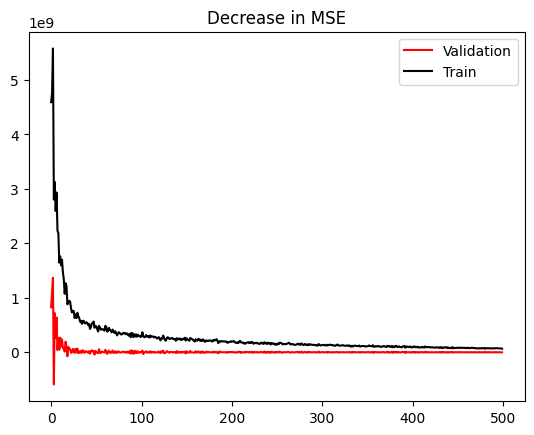

In [79]:
plt.plot(range(500),reg.oob_improvement_,color="red",label="Validation")
plt.plot(range(500),reg.train_score_,color="k",label="Train")
plt.title("Decrease in MSE")
plt.legend();

不难发现，随着迭代次数的增加，训练集上的损失函数一直有下降量，虽然下降量在逐渐变小，但是损失函数的确是在持续减下降的，相对的，验证集上的结果则在少有波动之后就维持在0附近不动了，也就是说模型的泛化能力在很早的时候就预见了瓶颈。如果我们开启提前停止，恐怕实际的迭代次数会远远少于我们给与的500次：

In [80]:
reg = GBR(n_estimators=500,learning_rate=0.1
          ,tol=1e-6 #非常非常低的阈值
          ,n_iter_no_change=5
          ,validation_fraction = 0.3
          ,subsample=0.3
          ,random_state=1412).fit(X,y)

In [81]:
reg.oob_improvement_.shape #实际我只迭代了69次

(69,)

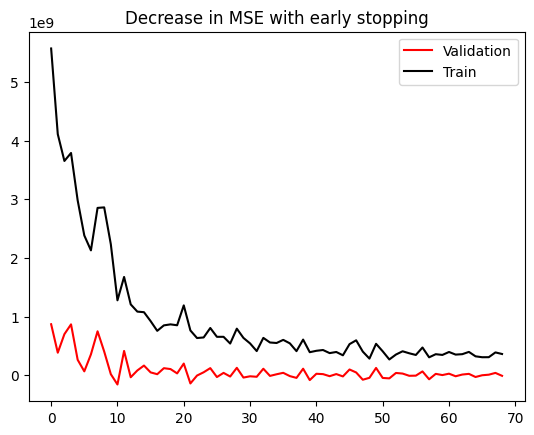

In [82]:
plt.plot(range(69),reg.oob_improvement_,color="red",label="Validation")
plt.plot(range(69),reg.train_score_,color="k",label="Train")
plt.title("Decrease in MSE with early stopping")
plt.legend();

不难发现，袋外数据的设置可以帮助我们快速把握模型的迭代情况，在当前数据集上，设置大约50以下的迭代次数，就足够使用了。因此在我们对GBDT进行超参数调优时，我们也有了天然的`n_estimators`的范围设置。当然，当我们调整其他参数（如`learning_rate`或者`max_depth`）之后，`n_estimators`的范围可能受到影响，但我们已经有了50这个可以参考的点。

奇怪的是，袋外数据是天然的验证数据，而提前停止时需要使用验证集的功能，但sklearn中并未配置直接使用袋外数据来进行提前停止的功能。如果能够使用袋外数据进行提前停止，则可以使用更多数据进行训练，这将会更加有利于模型的学习。

总结一下，与弱评估器训练数据相关的参数有：

|类型|参数|
|----|----|
|**弱评估器的训练数据**|参数：<br><br>&emsp;subsample：每次建树之前，从全数据集中进行有放回随机抽样的比例<br><br>&emsp;max_features：每次建树之前，从全特征中随机抽样特征进行分枝的比例<br><br>&emsp;random_state：随机数种子，控制整体随机模式<br><br>属性：<br><br>&emsp;<font color="green">**oob_improvement**</font>：每次建树之后相对于上一次袋外分数的增减<br><br>&emsp;<font color="green">**train_score_**</font>：每次建树之后相对于上一次验证时袋内分数的增减|

## 5 缺失的class_weight与n_jobs

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：n_estimators, learning_rate, <font color="green">**loss, alpha, init**</font><br>属性：<font color="green">**loss_, init_, estimators_**</font>|
|**弱评估器结构**|<font color="green">**criterion**</font>, max_depth, min_samples_split, min_samples_leaf, <br>min_weight_fraction_leaf, max_leaf_nodes,<br>min_impurity_decrease|
|**提前停止**|参数：<font color="green">**validation_fraction, n_iter_no_change, tol**</font><br>属性：<font color="green">**n_estimators_**</font>|
|**弱评估器的训练数据**|参数：subsample, max_features, random_state<br>属性：<font color="green">**oob_improvement, train_score_**</font>|
|**其他**|ccp_alpha, warm_start|

到这里，我们已经讲解完毕了梯度提升回归树以及梯度提升分类树中的所有参数。需要注意的是，作为最常用的集成算法之一，sklearn中的GBDT分类器并没有提供调节样本不均衡问题的参数class_weights，也不存在并行参数n_jobs。

不在样本不均衡问题上做文章，或许跟GBDT的弱评估器都是回归器有关，又或许是因为GBDT拥有非常强的学习能力，因此不会轻易被样本不均衡问题左右，也可能是因为sklearn在配置GBDT时存在一些失误。但务必要注意，如果样本存在严重不均衡的状况，那我们可能会考虑不使用梯度提升树，或者先对数据进行样本均衡的预处理后，再使用梯度提升树。

GBDT中的树必须一棵棵建立、且后面建立的树还必须依赖于之前建树的结果，因此GBDT很难在某种程度上实现并行，因此sklearn并没有提供n_jobs参数给Boosting算法使用。更加先进的Boosting算法们已经实现了分枝并行，但sklearn还无法实现这个功能，因此GBDT的计算速度难以得到加速，这是sklearn实现GBDT无法跨越的一个缺陷。

# 三 GBDT的参数空间与超参数优化

## 1 确定GBDT优化的参数空间

丰富的超参数为集成算法提供了无限的可能，以降低偏差为目的的Boosting算法们在调参之后的表现更是所向披靡，因此GBDT的超参数自动优化也是一个重要的课题。对任意集成算法进行超参数优化之前，我们需要明确两个基本事实：

1、不同参数对算法结果的影响力大小<br>
2、确定用于搜索的参数空间<br>

对GBDT来说，我们可以大致如下排列各个参数对算法的影响：

|影响力|参数|
|:-:|:-:|
|⭐⭐⭐⭐⭐<br>几乎总是具有巨大影响力|n_estimators（整体学习能力）<br>learning_rate（整体学习速率）<br>max_features（随机性）<br>|
|⭐⭐⭐⭐<br>大部分时候具有影响力|init（初始化）<br>subsamples（随机性）<br>loss（整体学习能力）|
|⭐⭐<br>可能有大影响力<br>大部分时候影响力不明显|max_depth（粗剪枝）<br>min_samples_split（精剪枝）<br>min_impurity_decrease（精剪枝）<br>max_leaf_nodes（精剪枝）<br>criterion（分枝敏感度）|
|⭐<br>当数据量足够大时，几乎无影响|random_state<br>ccp_alpha（结构风险）|

如果你熟悉随机森林的超参数，你会发现GBDT中大部分超参数的影响力等级都非常容易理解。树的集成模型们大多拥有相似的超参数，例如抗过拟合、用来剪枝的参数群（`max_depth`、`min_samples_split`等），又比如对样本/特征进行抽样的参数们（`subsample`，`max_features`等），这些超参数在不同的集成模型中以相似的方式影响模型，因此原则上来说，对随机森林影响较大的参数对GBDT也会有较大的影响。

然而你可能注意到，在随机森林中非常关键的`max_depth`在GBDT中没有什么地位，取而代之的是Boosting中特有的迭代参数学习率`learning_rate`。在随机森林中，我们总是在意模型复杂度(`max_depth`)与模型整体学习能力(`n_estimators`)的平衡，单一弱评估器的复杂度越大，单一弱评估器对模型的整体贡献就越大，因此需要的树数量就越少。在Boosting算法当中，单一弱评估器对整体算法的贡献由学习率参数`learning_rate`控制，代替了弱评估器复杂度的地位，因此Boosting算法中我们寻找的是`learning_rate`与`n_estimators`的平衡。同时，Boosting算法天生就假设单一弱评估器的能力很弱，参数`max_depth`的默认值也往往较小（在GBDT中`max_depth`的默认值是3），因此我们无法靠降低`max_depth`的值来大规模降低模型复杂度，更难以靠`max_depth`来控制过拟合，自然`max_depth`的影响力就变小了。

可见，虽然树的集成算法们大多共享相同的超参数，都由于不同算法构建时的原理假设不同，**相同参数在不同算法中的默认值可能被设置得不同，因此相同参数在不同算法中的重要性和调参思路也不同**。

在讲解随机森林时我们提到过，精剪枝工具的效用有限，剪枝一般还是大刀阔斧的粗剪枝更有效。在GBDT中，由于`max_depth`这一粗剪枝工具的默认值为3，因此在Boosting算法中通过削减模型复杂度来控制过拟合的思路就无法走通。特别地，参数`init`对GBDT的影响很大，如果在参数`init`中填入具体的算法，过拟合可能会变得更加严重，因此我们需要在抑制过拟合、控制复杂度这一点上令下功夫。

如果无法对弱评估器进行剪枝，最好的控制过拟合的方法就是增加随机性/多样性，因此`max_features`和`subsample`就成为Boosting算法中控制过拟合的核心武器，这也是GBDT中会加入Bagging思想的关键原因之一。依赖于随机性、而非弱评估器结构来对抗过拟合的特点，让Boosting算法获得了一个意外的优势：比起Bagging，Boosting更加擅长处理小样本高维度的数据，因为Bagging数据很容易在小样本数据集上过拟合。

需要注意的是，虽然`max_depth`在控制过拟合上的贡献不大，但是我们在调参时依然需要保留这个参数。当我们使用参数`max_features`与`subsample`构建随机性、并加大每一棵树之间的差异后，模型的学习能力可能受到影响，因此我们可能需要提升单一弱评估器的复杂度。因此在GBDT当中，`max_depth`的调参方向是放大/加深，以探究模型是否需要更高的单一评估器复杂度。相对的在随机森林当中，`max_depth`的调参方向是缩小/剪枝，用以缓解过拟合。

那在调参的时候，我们应该选择哪些参数呢？与随机森林一样，我们首先会考虑所有影响力巨大的参数（5星参数），当算力足够/优化算法运行较快的时候，我们可以考虑将大部分时候具有影响力的参数（4星）也都加入参数空间，如果样本量较小，我们可能不选择`subsample`。除此之外，我们还需要部分影响弱评估器复杂度的参数，例如`max_depth`。如果算力充足，我们还可以加入`criterion`这样或许会有效的参数。在这样的基本思想下，考虑到硬件与运行时间因素，我将选择如下参数进行调整，并使用基于TPE贝叶斯优化（HyperOpt）对GBDT进行优化——

|参数|
|:-:|
|`loss`|
|`criterion`|
|`init`|
|`n_estimators`|
|`learning_rate`|
|`max_features`|
|`subsamples`|
|`max_depth`|
|`min_impurity_decrease`|

在此基础上，我们需要进一步确认参数空间。幸运的是，GBDT的参数空间几乎不依赖于树的真实结构进行调整，且大部分参数都有固定的范围，因此我们只需要对无界的参数稍稍探索即可。

其中，我们在《二 4 袋外数据》部分已经对`n_estimators`进行过探索（如果你没有经过这个探索，则需要绘制绘制学习曲线进行探索），在当前默认参数下，我们大约只需要50次迭代就能够让损失函数收敛，因此我们可以就50这个数字向两侧展开来设置`n_estimators`的搜索范围。

另外，原则上来说需要用Tree对象来探索`min_impurity_decrease`的值，但由于我们这个参数只能放大、不能缩小，且我们知道精剪枝对于GBDT的影响较小，因此就不必大费周章地给与该参数一个精细的范围了，按照(0,C)结构走即可，其中C为任意常数。

具体每个参数的初始范围确定如下：

|参数|范围|
|:-:|:-:|
|`loss`|回归损失中4种可选损失函数<br>["squared_error","absolute_error", "huber", "quantile"]|
|`criterion`|全部可选的4种不纯度评估指标<br>["friedman_mse", "squared_error", "mse", "mae"]|
|`init`|HyperOpt不支持搜索，手动调参|
|`n_estimators`|经由提前停止确认中间数50，最后范围定为(25,200,25)|
|`learning_rate`|以1.0为中心向两边延展，最后范围定为(0.05,2.05,0.05)<br>*如果算力有限，也可定为(0.1,2.1,0.1)|
|`max_features`|所有字符串，外加sqrt与auto中间的值|
|`subsample`|subsample参数的取值范围为(0,1]，因此定范围(0.1,0.8,0.1)<br>*如果算力有限，也可定为(0.5,0.8,0.1)|
|`max_depth`|以3为中心向两边延展，右侧范围定得更大。最后确认(2,30,2)|
|`min_impurity_decrease`|只能放大、不能缩小的参数，先尝试(0,5,1)范围|

一般在初次搜索时，我们会设置范围较大、较为稀疏的参数空间，然后在多次搜索中逐渐缩小范围、降低参数空间的维度。需要注意的是，`init`参数中需要输入的评估器对象无法被HyperOpt库识别，因此参数`init`我们只能手动调参。在之前的课程《二 1.1 初始预测结果H0的设置》中，我们已经对`init`尝试过三种参数，分别是精调后的模型rf，字符串"zero"与"None"，并且我们已经看到rf给出的结果是最好的，因此我们就按照`init`= rf来设置参数，不再对该参数进行调整。

## 2 基于TPE对GBDT进行优化

In [48]:
#日常使用库与算法
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import cross_validate, KFold

#导入优化算法
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

In [49]:
data = pd.read_csv(r"..\datasets\House Price\train_encode.csv",index_col=0)

In [50]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [51]:
X.shape

(1460, 80)

> Step 1.建立benchmark

|算法|RF|AdaBoost|GBDT|RF<br>(TPE)|AdaBoost<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|1.29s|0.28s|0.49s|0.22s|0.27s|
|最优分数<br>(RMSE)|30571.267|35345.931|28783.954|28346.673|35169.730|

> Step 2.定义参数`init`需要的算法

In [52]:
rf = RFR(n_estimators=89, max_depth=22, max_features=14,min_impurity_decrease=0
         ,random_state=1412, verbose=False, n_jobs=-1)

> Step 3.定义目标函数、参数空间、优化函数、验证函数
>> 目标函数

In [67]:
def hyperopt_objective(params):
    reg = GBR(n_estimators = int(params["n_estimators"])
              ,learning_rate = params["lr"]
              ,criterion = params["criterion"]
              ,loss = params["loss"]
              ,max_depth = int(params["max_depth"])
              ,max_features = params["max_features"]
              ,subsample = params["subsample"]
              ,min_impurity_decrease = params["min_impurity_decrease"]
              ,init = rf
              ,random_state=1412
              ,verbose=False)
    
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    validation_loss = cross_validate(reg,X,y
                                     ,scoring="neg_root_mean_squared_error"
                                     ,cv=cv
                                     ,verbose=False
                                     ,n_jobs=-1
                                     ,error_score='raise'
                                    )
    return np.mean(abs(validation_loss["test_score"]))

>> 参数空间

|参数|范围|
|:-:|:-:|
|`loss`|回归损失中4种可选损失函数<br>["squared_error","absolute_error", "huber", "quantile"]|
|`criterion`|全部可选的4种不纯度评估指标<br>["friedman_mse", "squared_error", "mse", "mae"]|
|`init`|HyperOpt不支持搜索，手动调参|
|`n_estimators`|经由提前停止确认中间数50，最后范围定为(25,200,25)|
|`learning_rate`|以1.0为中心向两边延展，最后范围定为(0.05,2.05,0.05)<br>*如果算力有限，也可定为(0.1,2.1,0.1)|
|`max_features`|所有字符串，外加sqrt与auto中间的值|
|`subsample`|subsample参数的取值范围为(0,1]，因此定范围(0.1,0.8,0.1)<br>*如果算力有限，也可定为(0.5,0.8,0.1)|
|`max_depth`|以3为中心向两边延展，右侧范围定得更大。最后确认(2,30,2)|
|`min_impurity_decrease`|只能放大、不能缩小的参数，先尝试(0,5,1)范围|

In [68]:
param_grid_simple = {'n_estimators': hp.quniform("n_estimators",25,200,25)
                  ,"lr": hp.quniform("learning_rate",0.05,2.05,0.05)
                  ,"criterion": hp.choice("criterion",["friedman_mse", "squared_error"])
                  ,"loss":hp.choice("loss",["squared_error","absolute_error", "huber", "quantile"])
                  ,"max_depth": hp.quniform("max_depth",2,30,2)
                  ,"subsample": hp.quniform("subsample",0.1,0.8,0.1)
                  ,"max_features": hp.choice("max_features",["log2","sqrt",16,32,64])
                  ,"min_impurity_decrease":hp.quniform("min_impurity_decrease",0,5,1)
                 }

>> 计算参数空间大小：

In [69]:
len(range(25,200,25)) * len(np.arange(0.05,2.05,0.05)) * 4 * 4 * len(range(2,30,2)) * len(np.arange(0.1,0.8,0.1)) * 6 * len(range(0,5,1))

13171200

虽然参数分布较为稀疏，但由于参数维度众多、范围较大，因此这是一个超大的参数空间。

>> 优化函数

In [70]:
def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    early_stop_fn = no_progress_loss(100)
    
    #定义代理模型
    params_best = fmin(hyperopt_objective
                       , space = param_grid_simple
                       , algo = tpe.suggest
                       , max_evals = max_evals
                       , verbose=True
                       , trials = trials
                       , early_stop_fn = early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

>> 验证函数（可选）

In [66]:
def hyperopt_validation(params):    
    reg = GBR(n_estimators = int(params["n_estimators"])
              ,learning_rate = params["learning_rate"]
              ,criterion = params["criterion"]
              ,loss = params["loss"]
              ,max_depth = int(params["max_depth"])
              ,max_features = params["max_features"]
              ,subsample = params["subsample"]
              ,min_impurity_decrease = params["min_impurity_decrease"]
              ,init = rf
              ,random_state=1412 #GBR中的random_state只能够控制特征抽样，不能控制样本抽样
              ,verbose=False)
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    validation_loss = cross_validate(reg,X,y
                                     ,scoring="neg_root_mean_squared_error"
                                     ,cv=cv
                                     ,verbose=False
                                     ,n_jobs=-1
                                    )
    return np.mean(abs(validation_loss["test_score"]))

> Step 4.训练贝叶斯优化器

In [71]:
params_best, trials = param_hyperopt(30) #使用小于0.1%的空间进行训练

100%|████████████████████████████████████████████████| 30/30 [01:53<00:00,  3.77s/trial, best loss: 27068.736364252265]

 
 best params:  {'criterion': 1, 'learning_rate': 0.2, 'loss': 2, 'max_depth': 20.0, 'max_features': 4, 'min_impurity_decrease': 0.0, 'n_estimators': 25.0, 'subsample': 0.8} 



In [ ]:
params_best #注意hp.choice返回的结果是索引，而不是具体的数字

|参数|范围|
|:-:|:-:|
|`loss`|回归损失中4种可选损失函数<br>["squared_error","absolute_error", "huber", "quantile"]|
|`criterion`|全部可选的4种不纯度评估指标<br>["friedman_mse", "squared_error", "mse", "mae"]|
|`init`|HyperOpt不支持搜索，手动调参|
|`n_estimators`|经由提前停止确认中间数50，最后范围定为(25,200,25)|
|`learning_rate`|以1.0为中心向两边延展，最后范围定为(0.05,2.05,0.05)<br>*如果算力有限，也可定为(0.1,2.1,0.1)|
|`max_features`|所有字符串，外加sqrt与auto中间的值|
|`subsample`|subsample参数的取值范围为(0,1]，因此定范围(0.1,0.8,0.1)<br>*如果算力有限，也可定为(0.5,0.8,0.1)|
|`max_depth`|以3为中心向两边延展，右侧范围定得更大。最后确认(2,30,2)|
|`min_impurity_decrease`|只能放大、不能缩小的参数，先尝试(0,5,1)范围|

In [76]:
hyperopt_validation( {'criterion': "squared_error", 'learning_rate': 0.2, 'loss': "huber",
                      'max_depth': 20.0, 'max_features': 4, 'min_impurity_decrease': 0.0, 
                      'n_estimators': 25.0, 'subsample': 0.8} )

27261.907305034798

不难发现，我们已经得到了历史最好分数，但GBDT的潜力远不止如此。现在我们可以根据第一次训练出的结果缩小参数空间，继续进行搜索。在多次搜索中，我发现`loss`参数的最优选项基本都是平方误差"squared_error"，因此我们可以将该参数排除出搜索队伍。同样，对于其他参数，我们则根据搜索结果**修改空间范围、增加空间密度**，一般以被选中的值为中心向两边拓展，并减小步长，同时范围可以向我们认为会被选中的一边倾斜。例如最大深度`max_depth`被选为24，我们则将原本的范围(2,30,2)修改为(10,35,1)。同样`subsample`被选为0.7，我们则将新范围调整为(0.5,1.0,0.05)，依次类推。

In [77]:
param_grid_simple = {'n_estimators': hp.quniform("n_estimators",150,200,5)
                     ,"lr": hp.quniform("learning_rate",0.05,3,0.05)
                     ,"criterion": hp.choice("criterion",["friedman_mse", "squared_error"])
                     ,"max_depth": hp.quniform("max_depth",10,35,1)
                     ,"subsample": hp.quniform("subsample",0.5,1,0.05)
                     ,"max_features": hp.quniform("max_features",10,30,1)
                     ,"min_impurity_decrease":hp.quniform("min_impurity_decrease",0,5,0.5)
                    }

由于需要修改参数空间，因此目标函数也必须跟着修改：

In [78]:
def hyperopt_objective(params):
    reg = GBR(n_estimators = int(params["n_estimators"])
              ,learning_rate = params["lr"]
              ,criterion = params["criterion"]
              ,max_depth = int(params["max_depth"])
              ,max_features = int(params["max_features"])
              ,subsample = params["subsample"]
              ,min_impurity_decrease = params["min_impurity_decrease"]
              ,loss = "squared_error"
              ,init = rf
              ,random_state=1412
              ,verbose=False)
    
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    validation_loss = cross_validate(reg,X,y
                                     ,scoring="neg_root_mean_squared_error"
                                     ,cv=cv
                                     ,verbose=False
                                     ,n_jobs=-1
                                     ,error_score='raise'
                                    )
    return np.mean(abs(validation_loss["test_score"]))

In [79]:
params_best, trials = param_hyperopt(30) #使用小于0.1%的空间进行训练

100%|████████████████████████████████████████████████| 30/30 [01:04<00:00,  2.16s/trial, best loss: 26862.654104794165]

 
 best params:  {'criterion': 0, 'learning_rate': 0.15000000000000002, 'max_depth': 18.0, 'max_features': 21.0, 'min_impurity_decrease': 3.0, 'n_estimators': 200.0, 'subsample': 1.0} 



In [ ]:
params_best, trials = param_hyperopt(100) #尝试增加搜索次数

基于该结果，我们又可以确定进一步确定部分参数的值（比如criterion），再次缩小参数范围、增加参数空间的密集程度：

In [85]:
def hyperopt_objective(params):
    reg = GBR(n_estimators = int(params["n_estimators"])
              ,learning_rate = params["lr"]
              ,max_depth = int(params["max_depth"])
              ,max_features = int(params["max_features"])
              ,subsample = params["subsample"]
              ,min_impurity_decrease = params["min_impurity_decrease"]
              ,criterion = "friedman_mse"
              ,loss = "squared_error"
              ,init = rf
              ,random_state=1412
              ,verbose=False)
    
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    validation_loss = cross_validate(reg,X,y
                                     ,scoring="neg_root_mean_squared_error"
                                     ,cv=cv
                                     ,verbose=False
                                     ,n_jobs=-1
                                     ,error_score='raise'
                                    )
    return np.mean(abs(validation_loss["test_score"]))

In [86]:
param_grid_simple = {'n_estimators': hp.quniform("n_estimators",175,200,1)
                     ,"lr": hp.quniform("learning_rate",0.1,0.3,0.005)
                     ,"max_depth": hp.quniform("max_depth",8,22,1)
                     ,"subsample": hp.quniform("subsample",0.5,1,0.0025)
                     ,"max_features": hp.quniform("max_features",10,20,1)
                     ,"min_impurity_decrease":hp.quniform("min_impurity_decrease",1,4,0.25)
                    }

In [87]:
params_best, trials = param_hyperopt(300) #缩小参数空间的同时增加迭代次数

 42%|███████████████████▍                          | 127/300 [03:56<05:22,  1.86s/trial, best loss: 26643.104901081108]

 
 best params:  {'learning_rate': 0.26, 'max_depth': 18.0, 'max_features': 16.0, 'min_impurity_decrease': 1.5, 'n_estimators': 194.0, 'subsample': 0.9175} 



In [ ]:
def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    #early_stop_fn = no_progress_loss(100)
    
    #定义代理模型
    params_best = fmin(hyperopt_objective
                       , space = param_grid_simple
                       , algo = tpe.suggest
                       , max_evals = max_evals
                       , verbose=True
                       , trials = trials
                       #, early_stop_fn = early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

In [ ]:
params_best, trials = param_hyperopt(300) #取消提前停止，继续迭代

In [ ]:
params_best, trials = param_hyperopt(1000)

In [88]:
start = time.time()
hyperopt_validation({'criterion': "friedman_mse",
                     'learning_rate': 0.21,
                     'loss': "squared_error",
                     'max_depth': 8.0,
                     'max_features': 13,
                     'min_impurity_decrease': 3.5,
                     'n_estimators': 187.0,
                     'subsample': 0.8675})

26663.709257542465

In [89]:
end = (time.time() - start)
print(end)

11.501925706863403


|算法|RF|AdaBoost|GBDT|RF<br>(TPE)|AdaBoost<br>(TPE)|GBDT<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|1.29s|0.28s|0.49s|0.22s|0.27s|<font color="brown">**1.54s(↑)**</font>|
|最优分数<br>(RMSE)|30571.267|35345.931|28783.954|28346.673|35169.730|<font color="green">**26415.835(↓)**</font>|

GBDT获得了目前为止的最高分，虽然这一组参数最终指向了187棵树，导致GBDT运行所需的时间远远高于其他算法，GBDT上得到的分数是比精细调参后的随机森林还低2000左右，这证明了GBDT在学习能力上的优越性。由于TPE是带有强随机性的过程，因此如果我们多次运行，我们将得到不同的结果，但GBDT的预测分数可以稳定在26500上下。如果算力支持使用更多的迭代次数、或使用更大更密集的参数空间，我们或许可以得到更好的分数。同时，如果我们能够找到一组大学习率、小迭代次数的参数，那GBDT的训练速度也会随之上升。你可以试着在最初的范围中寻找另一个突破口，尝试将GBDT的速度降低。

# 四 原理进阶：GBDT的求解流程

## 1 GBDT的基本数学流程

作为当代众多经典算法的基础，GBDT的求解过程可谓十分精妙，它不仅开创性地舍弃了使用原始标签进行训练的方式，同时还极大地简化了Boosting算法的运算流程，让Boosting算法本该非常复杂的运算流程变得清晰简洁。当我们学过完整的AdaBoost流程后，我们会发现GBDT的数学流程非常简明、美丽，同时这一美丽的流程也是我们未来所有Boosting高级算法的数学基础。与任意Boosting算法一致，对GBDT我们需要回答如下问题：

- 损失函数$L(x,y)$的表达式是什么？损失函数如何影响模型构建？
- 弱评估器$f(x)$ 是什么，当下boosting算法使用的具体建树过程是什么？
- 综合集成结果$H(x)$是什么？集成算法具体如何输出集成结果？

同时，还可能存在其他需要明确的问题，例如：
- 是加权求和吗？如果是，加权求和中的权重如何求解？
- 训练过程中，拟合的数据$X$与$y$分别是什么？
- 模型训练到什么时候停下来最好？

对于GBDT，由于我们存在提前停止机制以及资源控制，因此我们一般不去在意模型停止相关的问题，但除此之外的每个问题我们都需要仔细研究。

---
**<font color="green"><center>依据上一个弱评估器$f(x)_{t-1}$的结果，计算损失函数$L(x,y)$，
    <br>并使用$L(x,y)$自适应地影响下一个弱评估器$f(x)_t$的构建。<br>集成模型输出的结果，受到整体所有弱评估器$f(x)_0$ ~ $f(x)_T$的影响。</center></font>**
---

回顾Boosting算法的基本指导思想，我们来梳理梯度提升树回归算法的基本流程。虽然Boosting理论很早就被人提出，但1999年才是GBDT算法发展的高潮。1999年，有四篇论文横空出世：

- 《贪心函数估计：一种梯度提升机器》<br>
Friedman, J. H. (February 1999). "Greedy Function Approximation: A Gradient Boosting Machine"

- 《随机梯度提升》<br>
Friedman, J. H. (March 1999). "Stochastic Gradient Boosting"

- 《梯度下降式提升算法》<br>
Mason, L.; Baxter, J.; Bartlett, P. L.; Frean, Marcus (1999). "Boosting Algorithms as Gradient Descent"

- 《函数空间中的梯度下降式提升算法》<br>
Mason, L.; Baxter, J.; Bartlett, P. L.; Frean, Marcus (May 1999). "Boosting Algorithms as Gradient Descent in Function Space"

今天我们学习的GBDT算法是融合了上述4篇论文思想的集大成之作。本次我们将基于sklearn中实现的GBDT来梳理数学流程，但不同的数学流程可能来自于上述不同的论文。需要注意的是，为了与之前课程中的符号表达相一致，我们将使用与原论文不同的符号，但数学过程将是完全相同的。

假设现有数据集$N$，含有形如$(x_i,y_i)$的样本$M$个，$i$为任意样本的编号，单一样本的损失函数为$l(y_i,H(x_i))$，其中$H(x_i)$是$i$号样本在集成算法上的预测结果，整个算法的损失函数为$L(y,H(x))$，且总损失等于全部样本的损失之和：$L(y,H(x)) = \sum_il(y_i,H(x_i))$。同时，弱评估器为回归树$f$，总共学习$T$轮。则GBDT回归的基本流程如下所示：

- 1) 初始化数据迭代的起点$H_0(x)$。sklearn当中，我们可以使用0、随机数或者任意算法的输出结果作为$H_0(x)$，但在最初的论文中，Friedman定义了如下公式来计算$H_0$：

$$
\begin{aligned}
H_0(x) &= \mathop{argmin}_{C} \sum_{i=1}^M l(y_i,C)\\ \\
&= \mathop{argmin}_{C} L(y,C)
\end{aligned}
$$

其中$y_i$为真实标签，$C$为任意常数。以上式子表示，找出令$\sum_{i=1}^Ml(y_i,C)$最小的常数$C$值，并输出最小的$\sum_{i=1}^Ml(y_i,C)$作为$H_0(x)$的值。需要注意的是，由于$H_0(x)$是由全部样本的$l$计算出来的，因此所有样本的初始值都是$H_0(x)$，不存在针对某一样本的单一初始值。<br>

开始循环，for t in 1,2,3...T:

> - 2) 在现有数据集$N$中，抽样$M$ * `subsample`个样本，构成训练集$N^t$<br><br>
> - 3) 对任意一个样本$i$，计算伪残差（pseudo-residuals）$r_{it}$，具体公式为：<br><br>
> $$r_{it} = -\frac{\partial{l(y_i,H_{t-1}(x_i))}}{\partial{H_{t-1}(x_i)}}$$ <br>
> 不难发现，伪残差是一个样本的损失函数对该样本在集成算法上的预测值求导后取负的结果，并且在进行第t次迭代、计算第t个伪残差时，我们使用的前t-1次迭代后输出的集成算法结果。在t=1时，所有伪残差计算中的$H_{t-1}(x_i)$都等于初始$H_0(x)$，在t>0时，每个样本上的$H_{t-1}(x_i)$都是不同的取值。<br><br>
> - 4) 求解出伪残差后，在数据集$(x_i, r_{it})$上按照**CART树**规则建立一棵回归树$f_t$，训练时拟合的标签为样本的伪残差$r_{it}$。<br><br>
> - 5) 将数据集$N_t$上所有的样本输入$f_t$进行预测，对每一个样本，得出预测结果$f_t(x_i)$。在数学上我们可以证明，**只要拟合对象是伪残差$r_{it}$，则$f_t(x_i)$的值一定能让损失函数最快减小**。<br><br>
> - 6) 根据预测结果$f_t(x_i)$迭代模型，具体来说：<br><br>
> $$H_t(x_i) = H_{t-1}(x_i) + f_t(x_i)$$<br>
> 假设输入的步长为$\eta$，则$H_t(x)$应该为：<br><br>
> $$H_t(x_i) = H_{t-1}(x_i) + \eta f_t(x_i)$$<br>
> 对整个算法则有：<br><br>
> $$H_t(x) = H_{t-1}(x) + \eta f_t(x)$$<br>

- 7. 循环结束，输出$H_T(x)$的值作为集成模型的输出值。

以上就是GBDT完整的数学流程，不难发现，这个流程是比AdaBoost的流程更简洁的。当然，整体流程当中可能有不少令人困惑的地方，我们来一一解明：

## 2 初始化$H_0$过程中的常数C是什么？

在最初的论文中，Friedman定义了如下公式来计算$H_0$：

$$
\begin{aligned}
H_0(x) &= \mathop{argmin}_{C} \sum_{i=1}^M l(y_i,C)\\ \\
&= \mathop{argmin}_{C} L(y_i,C)
\end{aligned}
$$

其中$y_i$为真实标签，$C$为任意常数。以上式子表示，找出令整体损失$L(y_i,C)$最小的常数$C$值，并输出最小的$L(y_i,C)$作为$H_0(x)$的值。在刚观察这个式子时，大家可能很难理解$C$这个常数的作用，但这个式子实际上很简单——

首先，$l$是损失函数，损失函数衡量两个自变量之间的差异，因此$l(y_i,C)$衡量样本$i$的真实标签$y_i$与常数C之间的差异，因此$L(y_i,C)$是所有样本的真实标签与常数C之间的差异之和。现在我们要找到一个常数C，令所有样本的真实标签与常数C的差异之和最小，请问常数C是多少呢？这是一个典型的求极值问题，只需要对$\sum_{i=1}^M l(y_i,C)$求导，再令导数为0就可以解出令$\sum_{i=1}^M l(y_i,C)$最佳的C。假设$l$是squared_error，每个样本的平方误差，则有：

$$\sum_{i=1}^M l(y_i,C) = \sum^M_{i=1}(y_i - C)^2$$

对上述式子求导，并令一阶导数等于0：

$$\begin{align}
\frac{\partial}{\partial C}\sum_{i=1}^M l(y_i,C) &= \frac{\partial}{\partial C} \sum^M_{i=1}(y_i - C)^2\\
&=\sum^M_{i=1}-2(y_i - C)\\
&=-2\sum^M_{i=1}y_i + 2MC\\
&= 0 \\
\end{align}$$

所以：

$$\begin{align}
2\sum^M_{i=1}y_i &= 2MC \\
C &= \frac{1}{M}\sum^M_{i=1}y_i \\ \\
C &= mean(y_i)
\end{align}$$

可知，**当L是平方误差squared error时，令$L(y_i,C)$最小的常数C就是真实标签的均值**，这个过程与我们在学习Kmeans时证明各点到质心（均值）的距离就是最小SSE完全一致。因此，式子$H_0 = \mathop{argmin}_{C} \sum_{i=1}^M l(y_i,C)$的本质其实是求解$C = mean(y_i)$时的损失函数，并以此损失函数作为$H_0$的值。当然，如果我们选择了其他的损失函数，我们就需要以其他方式（甚至梯度下降）进行求解，$C$的值可能也就不再是均值了。

## 3 伪残差与残差、梯度有什么关系？

在讲解GBDT与AdaBoost之间的差异时，我们曾提到，AdaBoost是拟合原始数据$X$与真实标签$y_i$，而GBDT拟合的是原始数据$X$与残差$(y_i - H(x_i))$，但在上述数学流程中，我们拟合的对象伪残差既不像真实标签，也不像$H(x)$与$y_i$的差异，它到底是什么呢？

$$r_{it} = -\frac{\partial{l(y_i,H_{t-1}(x_i))}}{\partial{H_{t-1}(x_i)}}$$

从数学上来看，伪残差是一个样本的损失函数对该样本在集成算法上的预测值求导后取负的结果。假设现在损失函数是平方误差Squared error，则该求导过程很明显就是：

$$
\begin{align}
l&= (y_i - H_{t-1}(x_i))^2 \\ \\ 
\frac{\partial l}{\partial H_{t-1}(x_i)} &= \frac{\partial}{\partial H_{t-1}(x_i)} (y_i - H_{t-1}(x_i))^2\\ \\
\frac{\partial l}{\partial H_{t-1}(x_i)} &= -2(y_i - H_{t-1}(x_i))\\ \\
- \frac{\partial l}{\partial H_{t-1}(x_i)}  &= 2(y_i- H_{t-1}(x_i))\\
\end{align}$$

不难发现，虽然伪残差看着与残差完全不相关，但其本质与残差非常相似。它是残差的某种变形，它的值不完全等同于残差的值，但是它衡量的差异与残差衡量的差异完全一致。因此，我可以让新建立的弱评估器拟合伪残差，这样算法就会更多地学习当下$H_t(x_i)$与$y_i$之间的差异，新建立的弱评估器预测出的结果也更有可能抹平这种差异。从直觉上来说，$H_t(x_i)$与$y_i$之间的差异越小，整体损失函数值就会越小，因此**GBDT拟合伪残差是在向着损失函数最小化（偏差最小化）的方向拟合**。

除此之外，伪残差是损失函数求导后取负的结果。一个函数对自变量求导后得到的结果称为**梯度**，代表字母为$g$，因此**伪残差也被称为负梯度**，也因此，GBDT被称为“拟合负梯度”的算法。这一说法拓展开来，我们可以说GBDT拟合负梯度、拟合伪残差、拟合损失函数在预测标签上的负导数。无论这些说法如何变化，其实指的都是同一个数学过程。不过，在最初的梯度提升机器（Gradient Boosting Machine）中，拟合的的确是残差$y-H(x)$，只不过在后来改进的梯度提升树中，拟合残差过程被修改为拟合伪残差了。

需要注意的是，由于伪残差/负梯度都是针对单一样本计算的，所以一般在数学公式当中，梯度会被表示为$g_i$，其中$i$为样本量。对GBDT来说则有：

$$r_i = -g_i$$

## 4 证明：拟合伪残差可以令损失函数最快地减小

从直觉上来看，拟合伪残差可以降低$H_t(x_i)$与$y_i$之间的差异，从而降低整体损失函数的值，但这个行为在数学上真的可行吗？毕竟，GBDT可以使用任意可微函数作为损失函数，不同损失函数求导后的结果即便与残差相似，也未必能代替真正的残差的效果。因此，不仅在直觉上需要理解拟合伪残差的作用，我们还需要从数学上证明：**只要拟合对象是伪残差$r_{it}$，则弱评估器的输出值$f_t(x_i)$一定是让损失函数减小最快的值。**

- 直观类比

假设现在有包含$M$个样本的数据集$N^t$，无论我们以什么规则建立新的弱评估器$f_t$，我们一定是希望$f_t$满足以下条件的：

$$
\begin{aligned}
f_t &= \mathop{argmin}_{f} L(y_i, H_t(x))\\
&= \mathop{argmin}_{f} \sum_{i=1}^{M}l(y_i, H_{t-1}(x_i) + f_t(x_i))
\end{aligned}
$$

上式表示，本轮弱评估器的输出值$f_t$应该是令整体损失$L$最小化的$f_t$。即，**无论弱评估器$f_t$是什么结构、什么规则、如何建立、如何拟合，其最终的输出值$f_t(x_i)$必须是令整体损失函数$L$最小化的**$f_t(x_i)$。如果我们能保证这个条件成立，那随着算法逐步迭代，损失函数必然是会越来越小的。那我们如何保证这一点成立呢？在这里，我们需要使用论文《梯度下降式提升算法》中所提到的函数式梯度下降了——我们可以直接对整体损失函数进行梯度下降，找出当前最小值以及最小值对应的$f_t(x_i)$。

具体来说，回忆我们在逻辑回归中执行的梯度下降过程，当时我们的损失函数为$L(\boldsymbol{w})$，其中$w$是逻辑回归的系数向量，且迭代$w$的方法如下：

$$w_{t} = w_{t-1} - \eta g_t$$

公式中$\eta$为学习率，$g_t$为第$t$次迭代中的梯度向量，包含了全部$w$的梯度$[g_1,g_2,g_3...g_n]$。通过在$w$上直接增加学习率\*负梯度，我们可以保证损失函数$L(\boldsymbol{w})$在$w$迭代过程中一定是越来越小的，因为在学习梯度下降时我们证明过，负梯度的方向就是损失函数下降最快的方向。那相同的思路也可以被用到GBDT当中。

在GBDT中，我们的损失函数为$L(y_i, H_t(x))$，并且我们的$H_t(x)$是按以下方式迭代的：

$$H_t(x) = H_{t-1}(x) + \eta f_t(x)$$

其中$H_t(x)$是，第$t$次迭代中全部样本在算法上的输出值，$f_t(x)$则是第$t$次迭代中全部样本在新弱评估器上输出的$f_t(x_i)$。原则上来说，对标传统梯度下降，只要让$f_t(x) = -g_t$，即让$f_t(x_i) = -g_i$，就一定能够保证损失函数$L(y_i,H_t(x))$是随迭代下降的。

当我们已经知道能够令损失函数最小的$f_t(x_i)$就是$-g_i$之后，如何逼迫新建立的弱评估器输出$-g_i$这个数字呢？答案是，让新建立的弱评估器拟合($x_i$,$-g_i$)。所以你现在应该已经猜到了，**每个样本的伪残差$r_i$（负梯度$-g_i$）其实就是能够令损失函数减小最快的$f_t(x_i)$的值**。

- 严谨证明

当然，上述过程只是类比，并非严谨的数学证明。如果我们想要证明负梯度就是让损失函数减小最快的值，则需要借助**泰勒级数**来帮助我们。

在数学中，泰勒级数使用无限个项的连加式来表示一个函数。实际应用当中，我们一般取有限项的连加式来逼近一个函数。当总共有N项时，连加式被叫做N阶泰勒展开（Nth-order Taylor approximation）。假设现在存在函数$f(x)$，则有：

> - **泰勒级数（无限项）**： 
$$f(x) = \sum_{n=0}^{\infty}\frac{f^{(n)}(a)}{n!}(x-a)^n$$

其中(x-a)是非常小的任意实数/复数，$n!$是n的阶乘，$f^{(n)}(a)$是函数$f(x)$的n阶导数在a点的取值。当a为0时，泰勒级数也被叫做麦克劳思级数。

> - **一阶泰勒展开**：
$$\begin{aligned}
f(x) &\approx \sum_{n=0}^{1}\frac{f^{(n)}a}{n!}(x-a)^n \\
&\approx f(a) + \frac{f'(a)}{1!}(x-a)
\end{aligned}
$$

> - **二阶泰勒展开**：
$$\begin{aligned}
f(x) &\approx \sum_{n=0}^{2}\frac{f^{(n)}a}{n!}(x-a)^n \\
&\approx f(a) + \frac{f'(a)}{1!}(x-a) + \frac{f''(a)}{2!}(x-a)^2
\end{aligned}
$$

> - **N阶泰勒展开**：
$$\begin{aligned}
f(x) &\approx \sum_{n=0}^{N}\frac{f^{(n)}a}{n!}(x-a)^n \\
&\approx f(a) + \frac{f'(a)}{1!}(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \frac{f'''(a)}{3!}(x-a)^3 + ...
\end{aligned}
$$

阶数越大，泰勒展开的值越接近$f(x)$的真实值。

我们可以对损失函数进行泰勒展开。对单一样本而言，我们有损失函数$l(y_i, H_{t-1}(x_i) + f_t(x_i))$，其中$y_i$是已知的常数，因此损失函数可以被看做是只有$H_{t-1}(x_i) + f_t(x_i)$一个自变量的函数，从而简写为$l(H_{t-1}(x_i) + f_t(x_i))$。

根据一阶泰勒展开，已知：

$$\begin{aligned}
f(x) &\approx f(a) + \frac{f'(a)}{1!}(x-a) \\
&\approx f(a) + f'(a)(x-a)
\end{aligned}
$$

令泰勒展开中的 x = $H_{t-1}(x_i) + f_t(x_i)$，令泰勒展开中的a = $H_{t-1}(x_i)$，则损失函数$l(H_{t-1}(x_i) + f_t(x_i))$可以被表示为：

$$\begin{aligned}
l(H_{t-1}(x_i) + f_t(x_i) ) &\approx l(H_{t-1}(x_i)) + \frac{\partial{l(H_{t-1}(x_i))}}{\partial{H_{t-1}(x_i)}} * f_t(x_i) \\
\end{aligned}
$$

不难发现，该式子中$H_{t-1}(x_i)$是常数，因此第一部分$l(y_i, H_{t-1}(x_i))$也是一个常数。同时，第二部分由导数和$f_t$组成，其中导数就是梯度，可以写作$g_i$，所以式子可以化简为：

$$\begin{aligned}
l(H_{t-1}(x_i) + f_t(x_i) ) &\approx 常数 + g_if_t(x_i) \\
\end{aligned}
$$

现在，如果要令$l$最小，$f_t(x_i)$应该等于多少呢？回到我们最初的目标，找出令损失函数$l$最小的$f_t$值：

$$
\begin{aligned}
f_t &= \mathop{argmin}_{f} \sum_{i=1}^{M}l(H_{t-1}(x_i) + f_t(x_i)) \\
& \approx \mathop{argmin}_{f} \sum_{i=1}^{M} \left( 常数 + g_if_t(x_i) \right)
\end{aligned}
$$

常数无法被最小化，因此继续化简：
$$
\begin{aligned}
f_t &\approx \mathop{argmin}_{f} \sum_{i=1}^{M} g_if_t(x_i) \\ \\
&\approx \mathop{argmin}_{f} \langle g_t f_t(x) \rangle
\end{aligned}
$$

现在，$g_t$是包含了所有样本梯度的向量，$f_t(x)$是包含了所有样本在$f_t$上预测值的向量，两个向量对应位置元素相乘后求和，即表示为向量的内积，由尖括号$ \langle \rangle$表示。现在我们希望求解向量内积的最小值、并找出令向量内积最小的$f_t(x)$的取值，那就必须先找出$f_t(x)$的方向，再找出$f_t(x)$的大小。

In [ ]:
[g1f(x1) + g2f(x2) + g3(fx3)...gM(fxM)]

In [ ]:
[g1,g2,g3....gM] - 梯度向量
[f(x1),f(x2),f(x3)....f(xM)] - ft决策树上输出的所有样本的预测值

- 方向

$f_t(x)$**的方向应该与$g_t$完全相反**。向量的内积$\langle g_t f_t(x) \rangle = |g_t||f_t(x)|cos(\alpha)$，其中前两项为两个向量的模长，$\alpha$是两个向量的夹角大小。模长默认为整数，因此当且仅当两个向量的方向完全相反，即夹角大小为180度时，$cos(\alpha)$的值为-1，才能保证两个向量的内积最小。假设向量 a = [1,2]，向量b是与a的方向完全相反的向量。假设a和b等长，那向量b就是[-1,-2]。因此，与$g_t$方向完全相反且等长的向量就是$-g_t$，$f_t(x)$的方向也正是$-g_t$的方向。

![](https://qph.fs.quoracdn.net/main-qimg-eff9b21e0b8061546e9a661b662d2860)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021MachineLearning/Ensembles/Public/sisis.png)

- 大小

对于向量a，除了[-1,-2]之外，还存在众多与其呈180度夹角、但大小不一致的向量，比如[-2,-4], [-0.5,-1]，每一个都可以与向量a求得内积。并且我们会发现，当方向相反时，向量b中的元素绝对值越大，b的模长就越长，向量a与b的内积就越小。因此不难发现，$\langle g_t f_t(x) \rangle$是一个理论上可以取到无穷小的值，那我们的$f_t(x)$应该取什么大小呢？**答案非常出乎意料：任何大小都无所谓**。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021MachineLearning/Ensembles/Public/sisisi2.png)

回到我们的迭代公式：

$$
H_t(x) = H_{t-1}(x) + \eta f_t(x)
$$

$$
l(H_{t-1}(x_i) + f_t(x_i) ) \approx 常数 + g_if_t(x_i)
$$

无论$f_t(x)$的大小是多少，我们都可以通过步长$\eta$对其进行调整，只要能够影响$H_(x)$，我们就可以影响损失迭代过程中的常数的大小。**因此在数学上来说，$f_t(x)$的大小可以是$-g_t$的任意倍数**，这一点在梯度下降中其实也是一样的。为了方便起见，同时为了与传统梯度下降过程一致，我们通常让$f_t(x)$就等于一倍的$-g_t$，但也有不少论文令$f_t(x)$等于其他值的。在GBDT当中：

$$
\begin{aligned}
f_t &\approx \mathop{argmin}_{f} \langle g_t f_t(x) \rangle\\
&= -g_t
\end{aligned}
$$

这就是我们让GBDT当中的弱评估器拟合伪残差/负梯度的根本原因。拟合负梯度其实为GBDT带来了非常多的特点——

1. 首先，通过直接拟合负梯度，GBDT避免了从损失函数找“最优”的过程，即避免了上述证明中求解$f_t = \mathop{argmin}_{f} \sum_{i=1}^{M}l(H_{t-1}(x_i) + f_t(x_i))$的过程，从而大大地简化了计算。

2. 其次，通过拟合负梯度，GBDT模拟了梯度下降的过程，由于结合了传统提升法Boosting与梯度下降，因此才被命名为梯度提升法（Gradient Boosting）。这个过程后来被称为**函数空间上的梯度下降**（Gradient Descent in Function Space），这是视角为Boosting算法的发展奠定了重要的基础。

3. 最后，最重要的一点是，通过让弱评估器拟合负梯度，弱评估器上的结果可以直接影响损失函数、保证损失函数的降低，从而指向Boosting算法的根本目标：降低偏差。这一过程避免了许多在其他算法中需要详细讨论的问题：例如，每个弱评估器的权重$\phi$是多少，以及弱评估器的置信度如何。

在AdaBoost算法当中，损失函数是“间接”影响弱评估器的建立，因此有的弱评估器能够降低损失函数，而有的弱评估器不能降低损失函数，因此要在求和之前，需要先求解弱评估器的置信度，然后再给与置信度高的评估器更高的权重，权重$\phi$存在的根本意义是为了调节单一弱评估器对$H(x)$的贡献程度。但在GBDT当中，由于所有的弱评估器都是能够降低损失函数的，只不过降低的程度不同，因此就不再需要置信度/贡献度的衡量，因此就不再需要权重$\phi$。

如果去翻阅早期梯度提升机器资料，我们会发现梯度提升树最开始是有求解权重的过程的。当拟合完伪残差之后，我们不直接求解令$L$最小的$f_t$值，而求解令整体$L$最小的权重$\phi$：

> 求解迭代过程中弱评估器$f_t$所需的权重$\phi_t$，具体公式为：<br><br>
> $$ \phi_t = \mathop{argmin}_{\phi} \sum_{i=1}^M L\left(y_i,H_{t-1}(x_i) + \phi_tf_t(x_i) \right) $$<br>
> 与求解$H_0$的式子相似，上述式子表示，找出令$\sum_{i=1}^M L\left(y_i,H_{t-1}(x_i) + \phi_tf_t(x_i) \right)$最小的常数$\phi_t$值。同样，由于$\phi_t$是针对全部样本计算出来的，因此$f_t$上所有样本的预测值前的权重都是$\phi_t$，并不存在针对于某一样本的权重。<br><br>
> 接着，再根据求解出的权重$\phi_t$迭代模型，具体来说：<br><br>
> $$H_t(x) = H_{t-1}(x) + \eta \phi_t f_t(x)$$

在此基础上，Friedman甚至还提出了单独针对决策树的权重计算方法。但我们之前推导中讲解过，只要$f_t(x)$的方向正确，$f_t(x)$具体的取值并没有那么重要，毕竟可以通过学习率$\eta$进行调整。在有$\eta$、同时又不需要衡量弱评估器置信度的情况下，权重$\phi$的意义就很小了。因此现在我们在实现梯度提升树时，已经不再使用带权重的版本，但带权重版本的数学过程与不带权重版本是高度类似的。

讲到这里，梯度提升树相关的知识也就讲解完毕了。在课程当中我们专注于GBDT回归的讲解，是因为GBDT分类问题就是在回归问题的流程上令$p(x) = \sigma(H(x))$，其中$\sigma$依情况而定可能是softmax也可能是sigmoid或其他函数。如果你对GBDT分类感兴趣，可以阅读原理进阶部分提到的4篇论文，里面有大量关于分类问题的讲解。现在，我们已经了解了整个GBDT的数学流程，这部分流程是未来XGBoost、LGBM等算法的基础。如果你对Boosting算法的数学理论有相应的需求，请务必熟读GBDT原理相关的内容。